In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd

<h2>Settings</h2>

In [2]:
result_dir = ""

compiler_type_vms = ["asmble", "wasmer", "wavm"]

interpreter_type_vms = ["life", "wasmi"] # TODO: add wagon after result has been collected

# the list of enabled test names
test_names = ["snappy_compression_5_1000000_1Kb", \
              "snappy_compression_5_10_100Mb", \
              "deflate_compression_5_100000_1Kb", \
              "deflate_compression_5_5_100Mb", \
              "fibonacci_38", \
              "factorization_2147483647", \
              "recursive_hash_10000000_0", \
              "matrix_product_1_10_1000000", \
              "matrix_product_1_500_100", \
              "svd_decomposition_1_10_1000000", \
              "svd_decomposition_1_300_100", \
              "qr_decomposition_1_10_1000000", \
              "qr_decomposition_1_500_100"]

<h2>Import results</h2>

In [3]:
from collections import defaultdict

def read_results(file_name):
    results = defaultdict(list)
    csv_results = pd.read_csv(file_name)
    for test_name, elapsed_time in zip(csv_results["test_name"], csv_results["elapsed_time"]):
        results[test_name].append(elapsed_time)
        
    return results

In [4]:
from os.path import join

vm_results = {}
for compiler_vm in compiler_type_vms:
    vm_results[compiler_vm] = read_results(join(result_dir, compiler_vm + ".csv"))

for interpreter_vm in interpreter_type_vms:
    vm_results[interpreter_vm] = read_results(join(result_dir, interpreter_vm + ".csv"))

<h2>Results preparation</h2>

In [5]:
tests_result = defaultdict(list)
df_results = {}
interpreter_tests_result = {}

for test_name in test_names:
    for vm_name in vm_results:
        tests_result[test_name].append(vm_results[vm_name][test_name])
        
    df_results[test_name] = pd.DataFrame(pd.DataFrame(tests_result[test_name]).T.values, columns=vm_results.keys())

<h2>Result statistics</h2>

In [6]:
for test_name in test_names:
    print("{}\n{}\n".format(test_name, df_results[test_name].describe()))

snappy_compression_5_1000000_1Kb
          asmble     wasmer       wavm         life        wasmi
count  11.000000  11.000000  11.000000     3.000000     3.000000
mean   27.509278  38.289971  13.603409  4489.894337  1982.833807
std     0.139130   0.306925   0.092356     0.698231     1.957743
min    27.285796  38.057326  13.558479  4489.130545  1981.034256
25%    27.392895  38.114557  13.566798  4489.591594  1981.791472
50%    27.534367  38.144967  13.572578  4490.052643  1982.548688
75%    27.631515  38.309500  13.583830  4490.276233  1983.733582
max    27.703752  39.042619  13.877442  4490.499823  1984.918476

snappy_compression_5_10_100Mb
          asmble     wasmer       wavm         life        wasmi
count  11.000000  11.000000  11.000000     3.000000     3.000000
mean   20.689402  23.091201   9.644523  2501.841140  1091.431735
std     0.138434   0.326162   0.020368    11.638523     4.680804
min    20.478251  22.934610   9.588622  2491.425814  1086.784157
25%    20.578294  22.94653

<h2>Box plots</h2>

In [7]:
fontsize=15

def adjust_line2D_linewidth(line2d, box_line_width, whisker_line_width, cap_line_width, median_line_width):
    for box in line2d['boxes']:
        box.set(linewidth=box_line_width)
    
    for whisker in line2d['whiskers']:
        whisker.set(linewidth=whisker_line_width)

    for cap in line2d['caps']:
        cap.set(linewidth=cap_line_width)

    for median in line2d['medians']:
        median.set(linewidth=median_line_width)
        
def draw_plotbox(df, column, figsize, test_name, fontsize):
    lines = df.boxplot(figsize=figsize, column=column, return_type='dict', widths=0.5, fontsize=fontsize, showmeans=True)
    adjust_line2D_linewidth(lines, 2, 1, 1, 1)
    plt.title(test_name, fontsize=fontsize)
    plt.ylabel("sec", fontsize=fontsize)
    plt.show()
    
def draw_plot(df, columns, figsize, test_name, fontsize, isLogY=False):
    df[columns].plot(style="o-", figsize=figsize, fontsize=fontsize)
    plt.title(test_name, fontsize=fontsize)
    plt.ylabel("sec", fontsize=fontsize)
    if isLogY:
        plt.yscale("log")
    plt.grid()


<h3>snappy_compression_5_1000000_1Kb</h3>

In [8]:
plot_test_name="snappy_compression_5_1000000_1Kb"
figsize=(12,10)

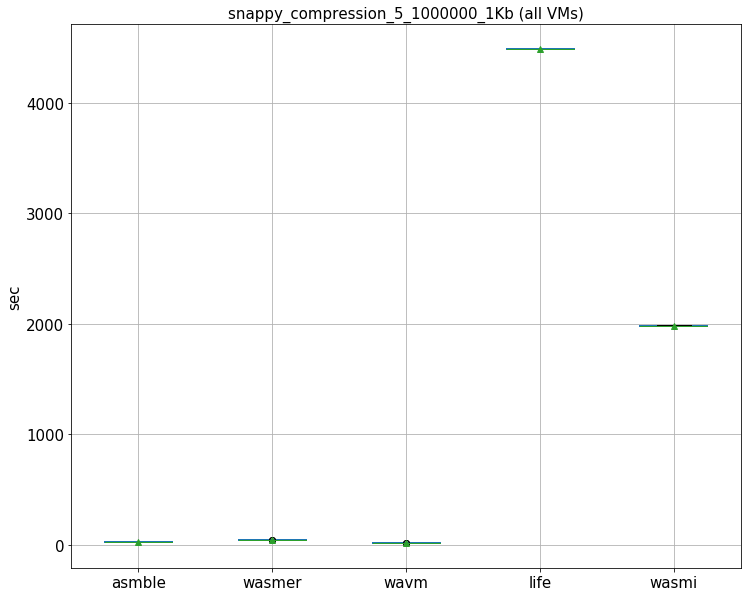

In [9]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize)

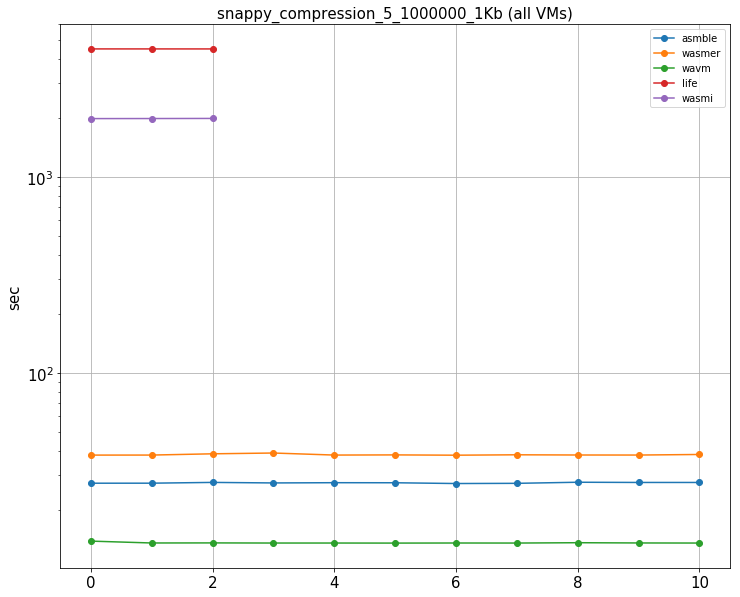

In [10]:
draw_plot(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize, True)

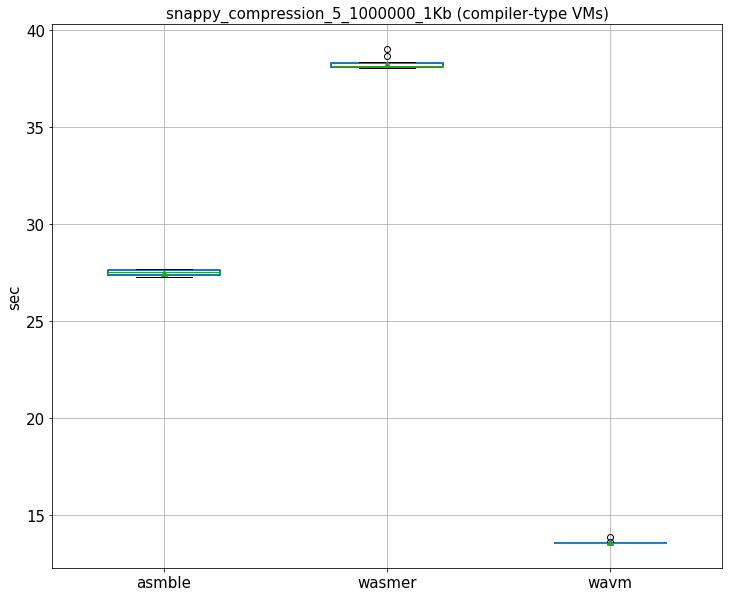

In [11]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

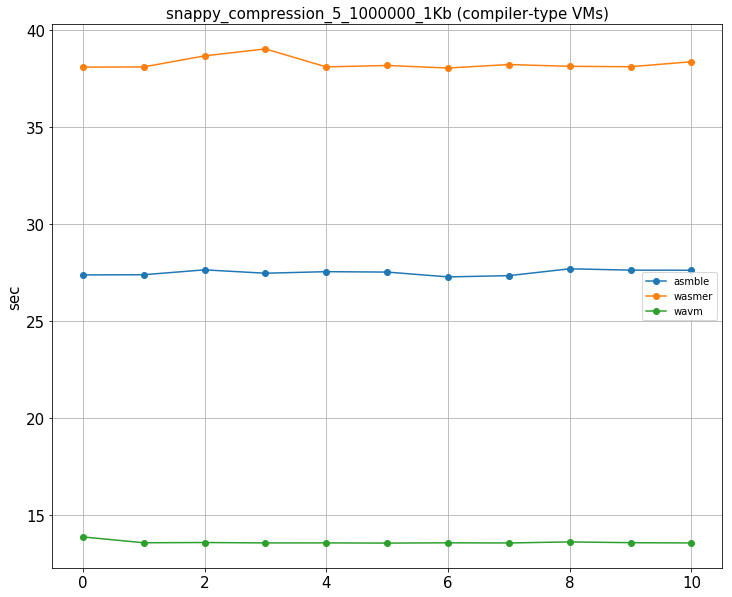

In [12]:
draw_plot(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

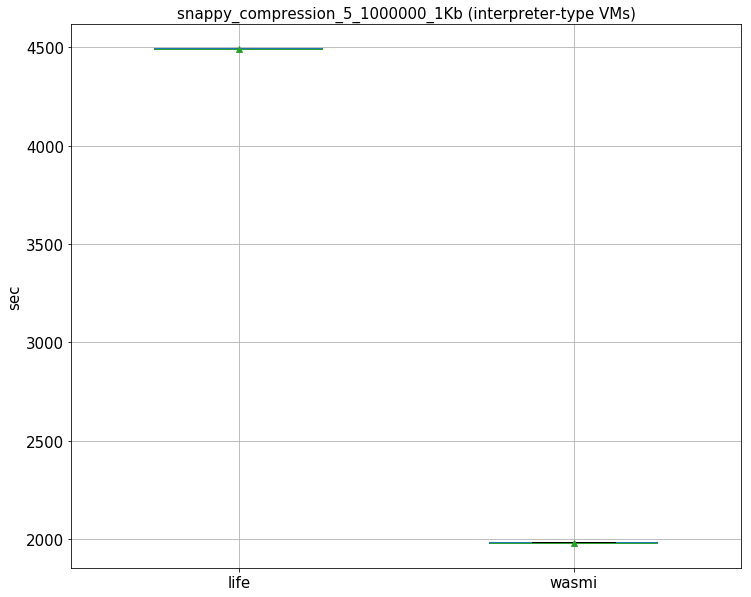

In [13]:
draw_plotbox(df_results[plot_test_name], interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

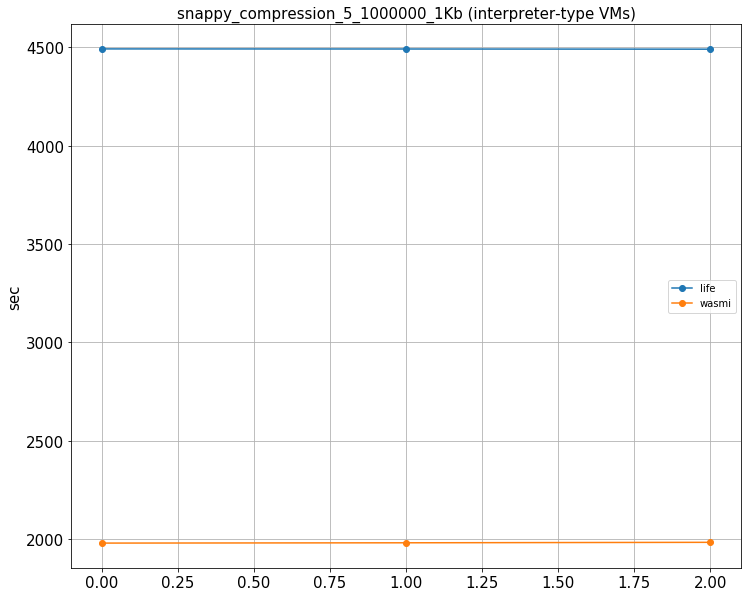

In [14]:
draw_plot(df_results[plot_test_name],  interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

<h3>snappy_compression_5_10_100Mb</h3>

In [15]:
plot_test_name="snappy_compression_5_10_100Mb"
figsize=(12,10)

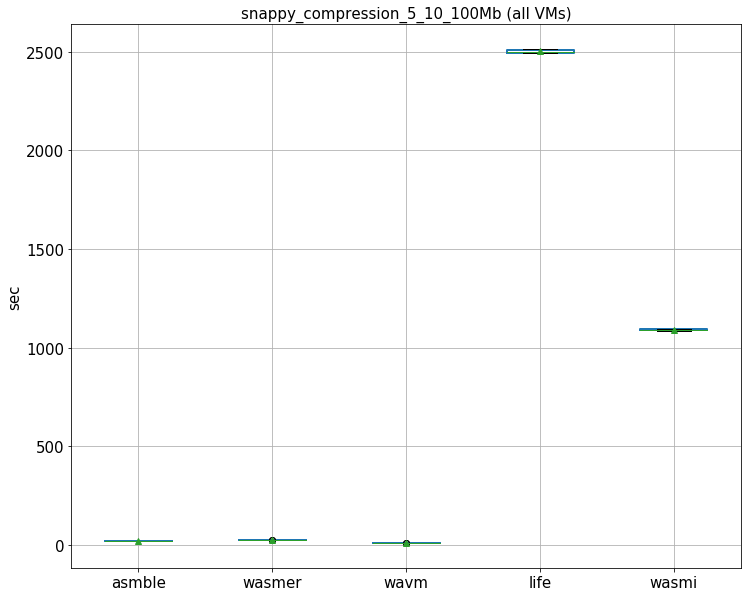

In [16]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize)

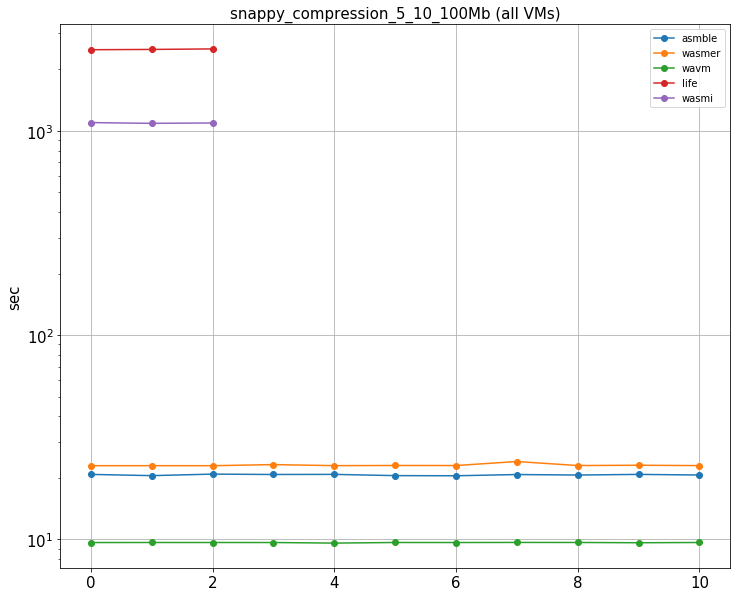

In [17]:
draw_plot(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize, True)

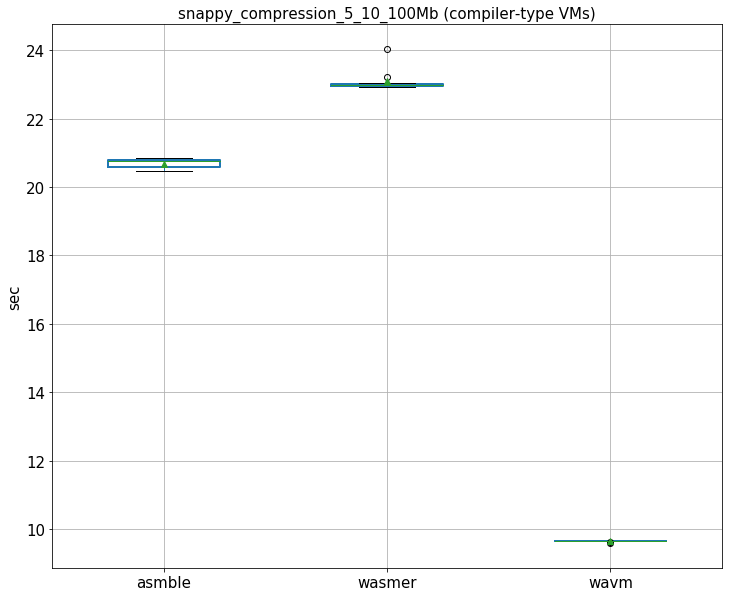

In [18]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

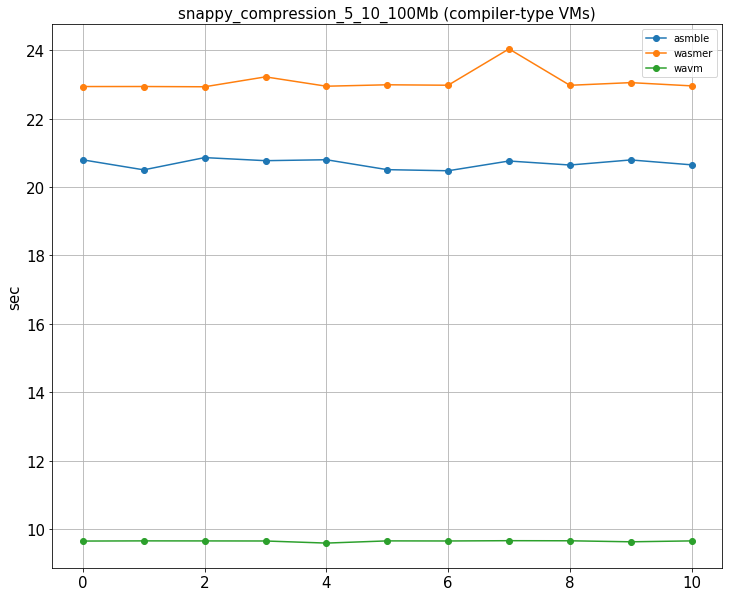

In [19]:
draw_plot(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

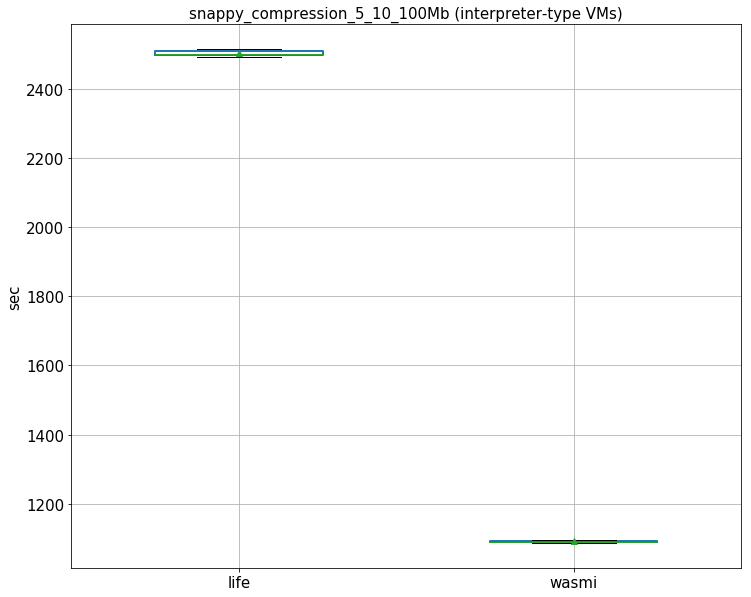

In [20]:
draw_plotbox(df_results[plot_test_name], interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

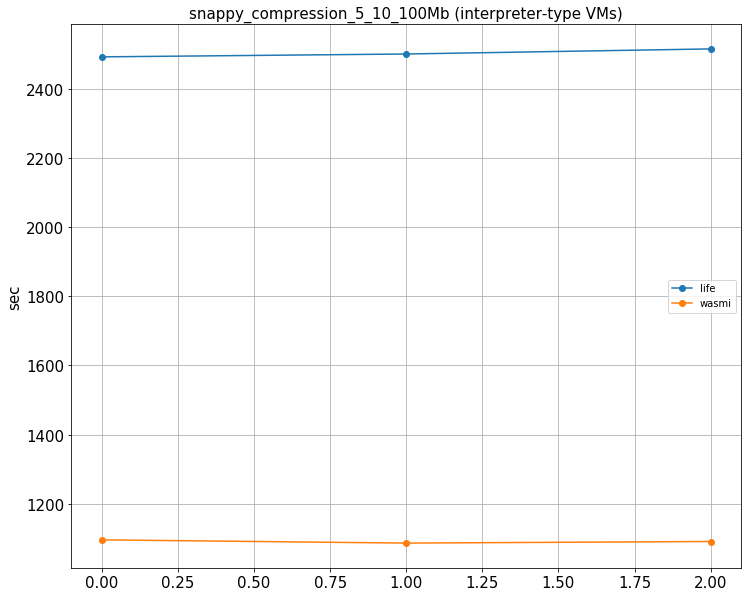

In [21]:
draw_plot(df_results[plot_test_name],  interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

<h3>deflate_compression_5_100000_1Kb</h3>

In [22]:
plot_test_name="deflate_compression_5_100000_1Kb"
figsize=(12,10)

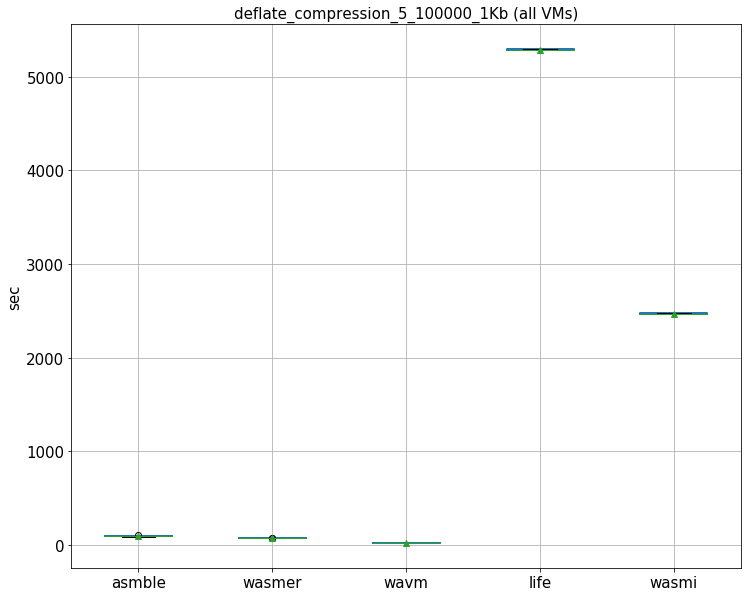

In [23]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize)

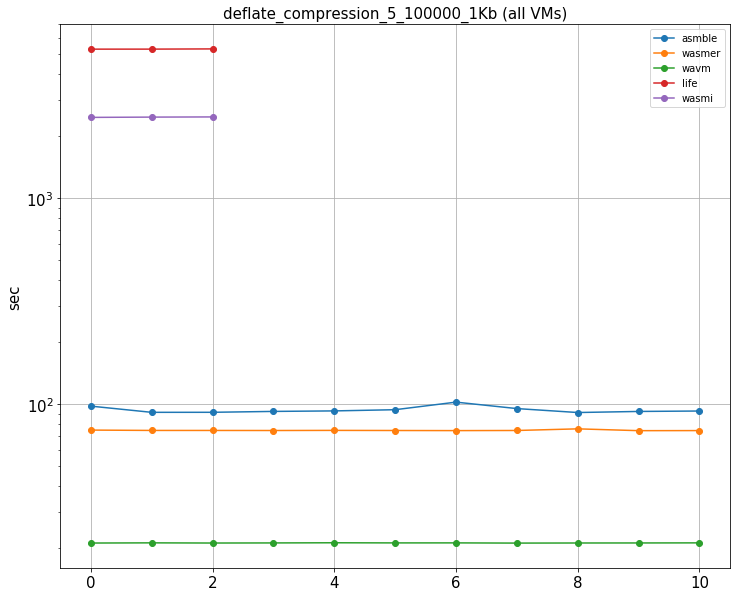

In [24]:
draw_plot(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize, True)

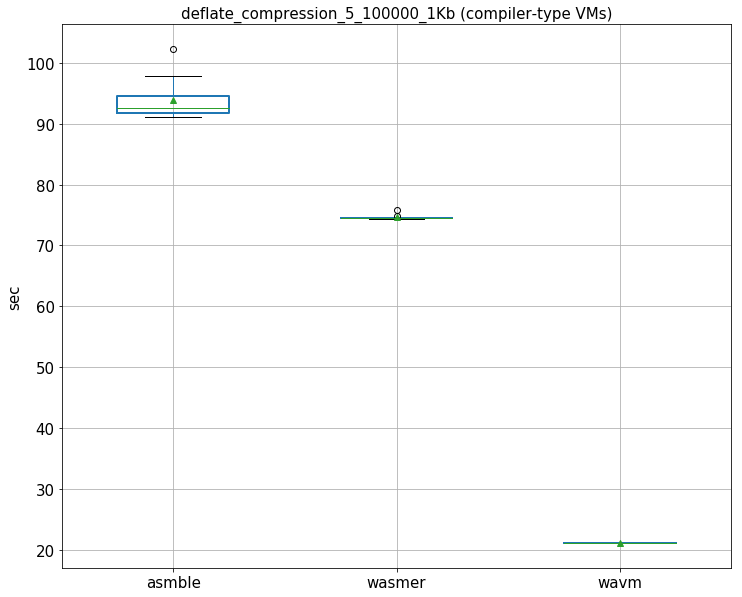

In [25]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

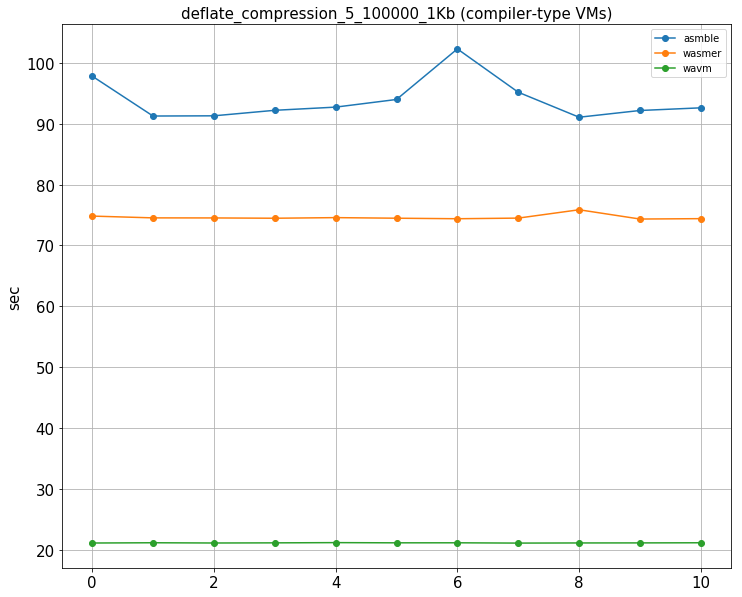

In [26]:
draw_plot(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

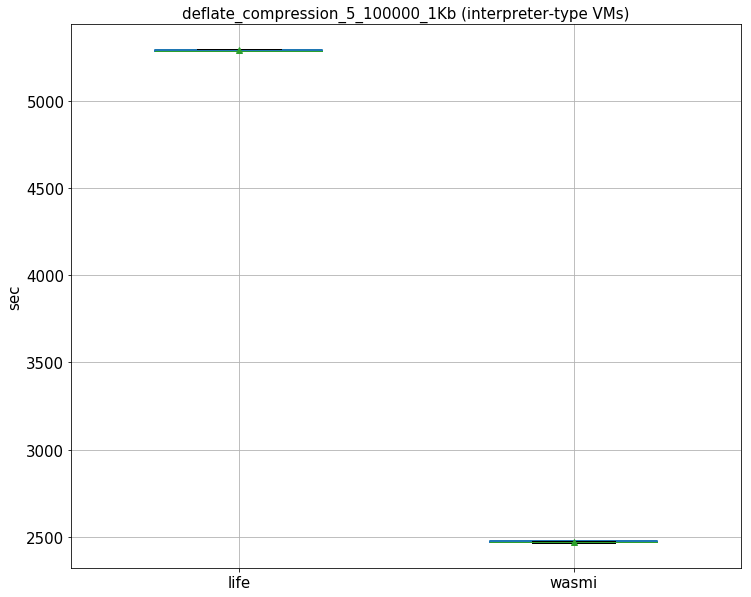

In [27]:
draw_plotbox(df_results[plot_test_name], interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

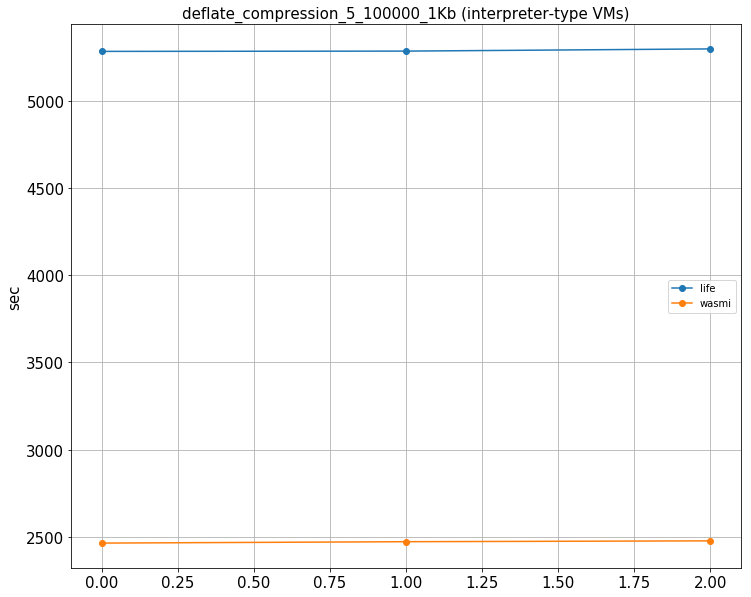

In [28]:
draw_plot(df_results[plot_test_name],  interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

<h3>deflate_compression_5_5_100Mb</h3>

In [29]:
plot_test_name="deflate_compression_5_5_100Mb"
figsize=(12,10)

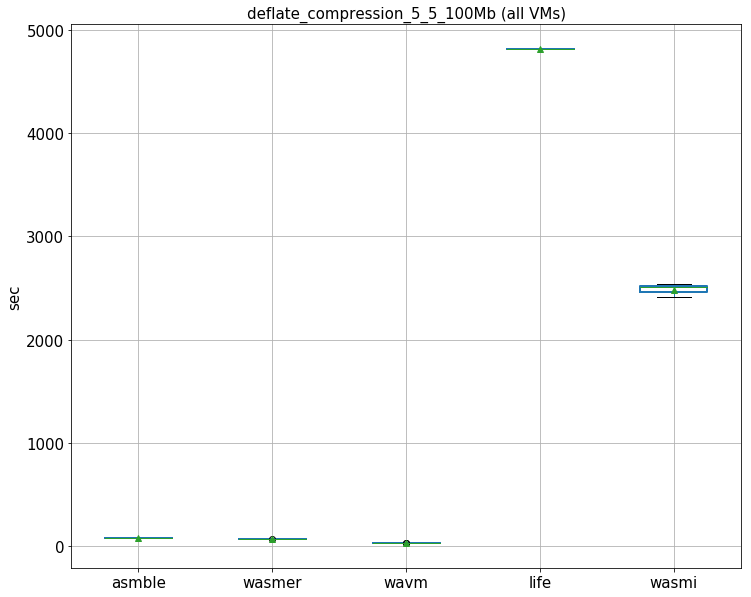

In [30]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize)

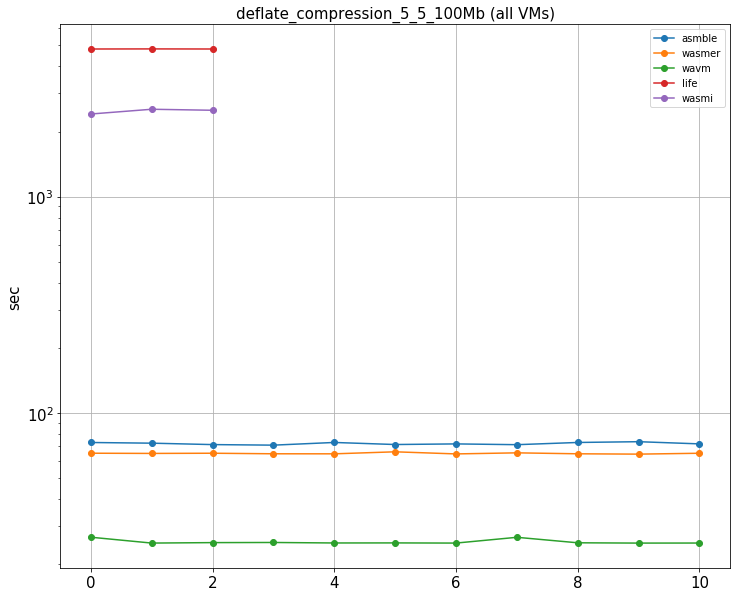

In [31]:
draw_plot(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize, True)

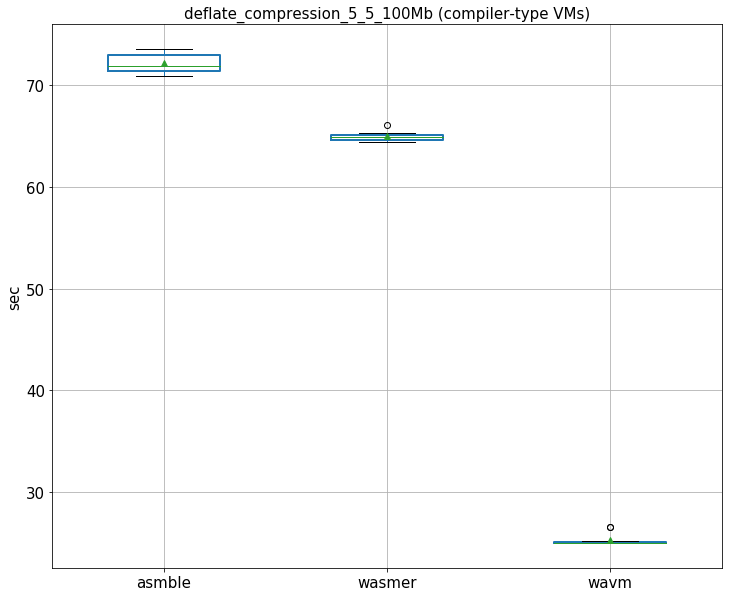

In [32]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

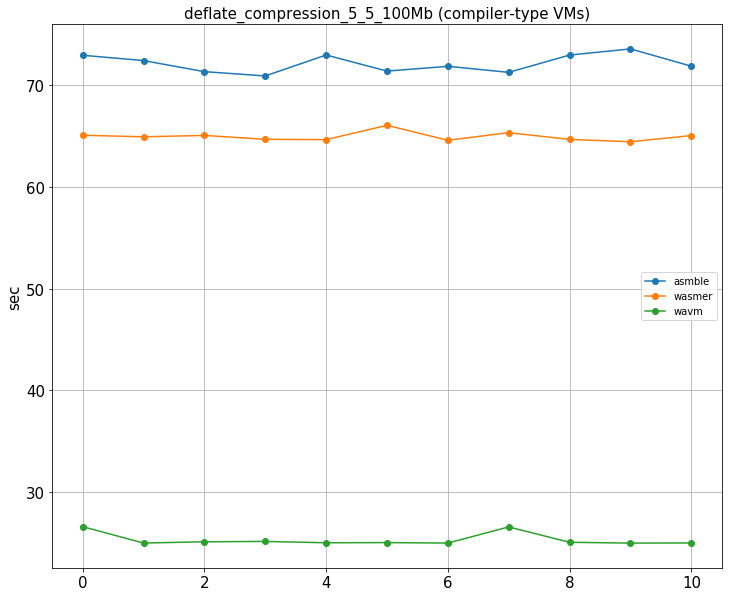

In [33]:
draw_plot(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

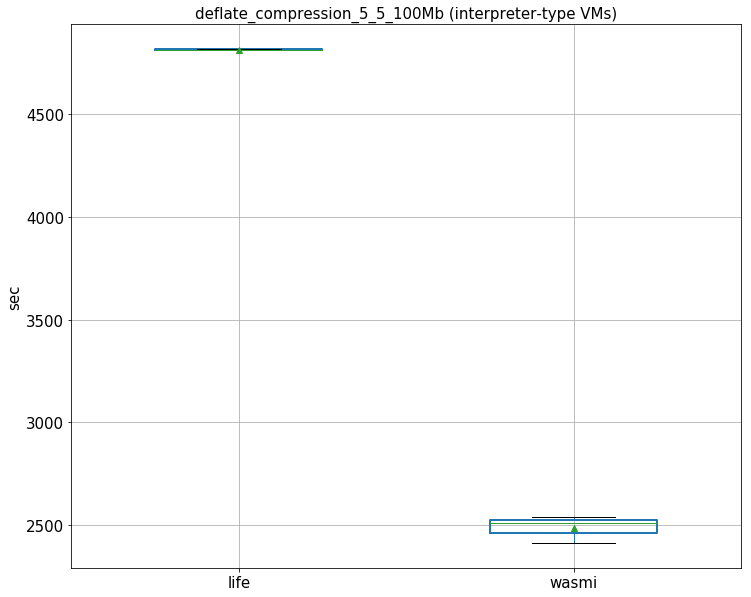

In [34]:
draw_plotbox(df_results[plot_test_name], interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

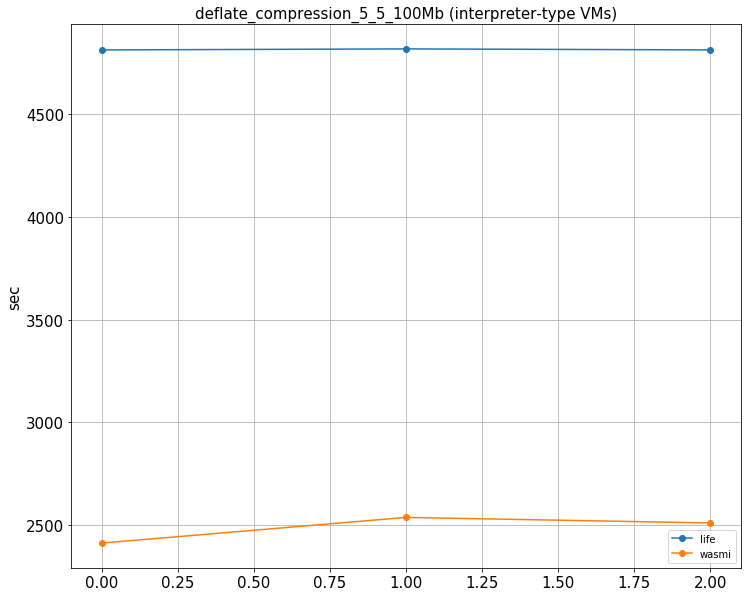

In [35]:
draw_plot(df_results[plot_test_name],  interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

<h3>fibonacci_38</h3>

In [36]:
plot_test_name="fibonacci_38"
figsize=(12,10)

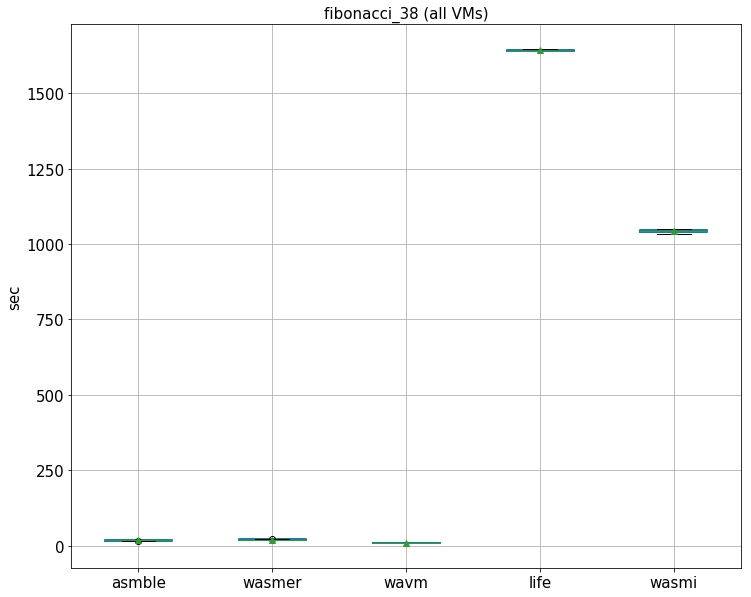

In [37]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize)

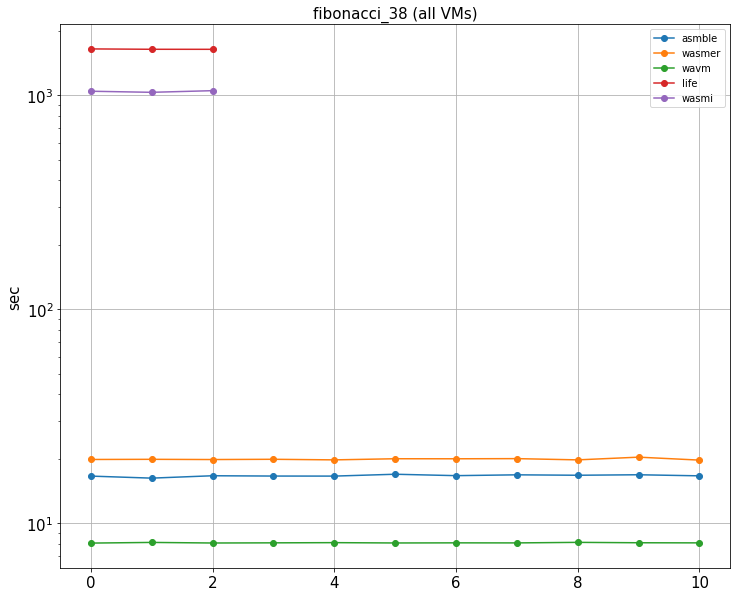

In [38]:
draw_plot(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize, True)

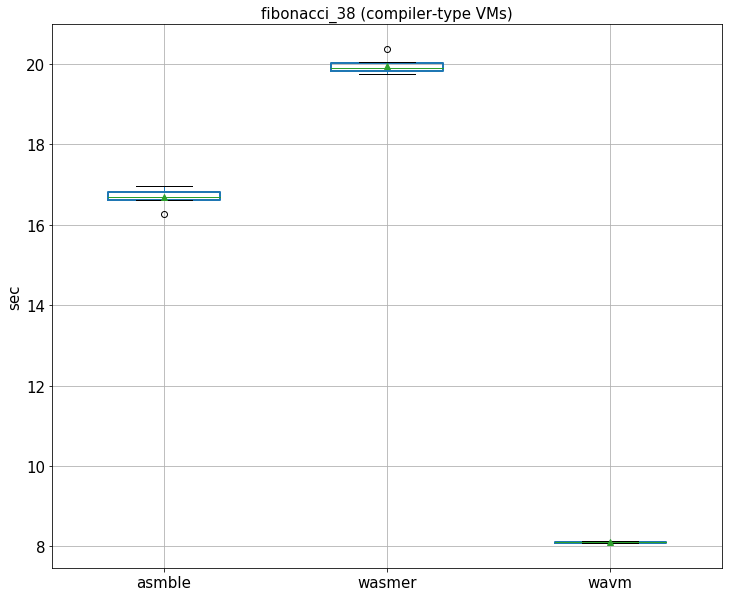

In [39]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

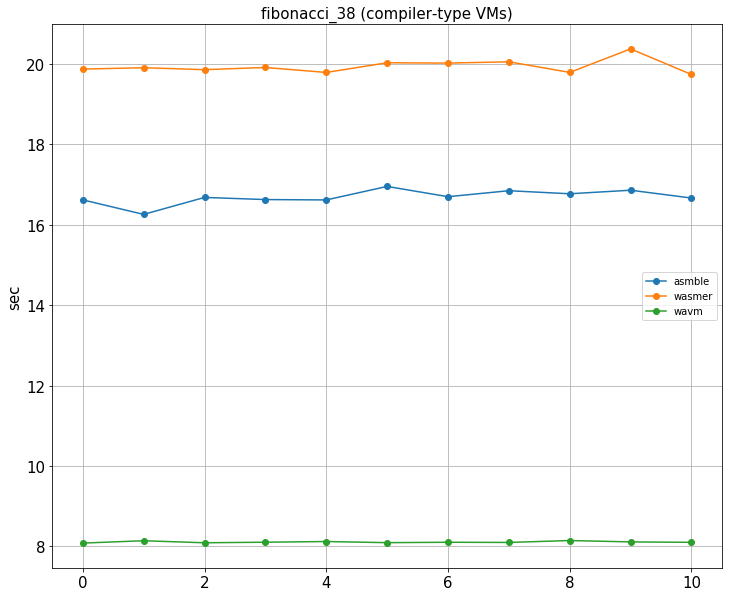

In [40]:
draw_plot(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

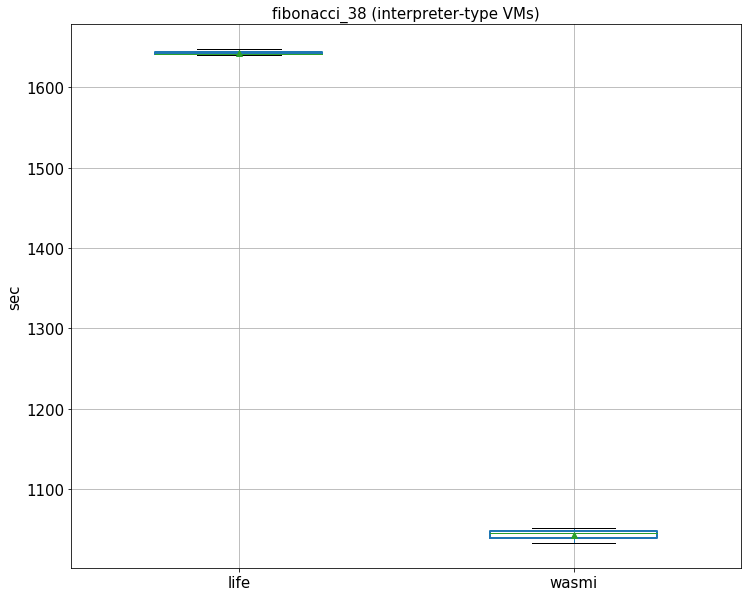

In [41]:
draw_plotbox(df_results[plot_test_name], interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

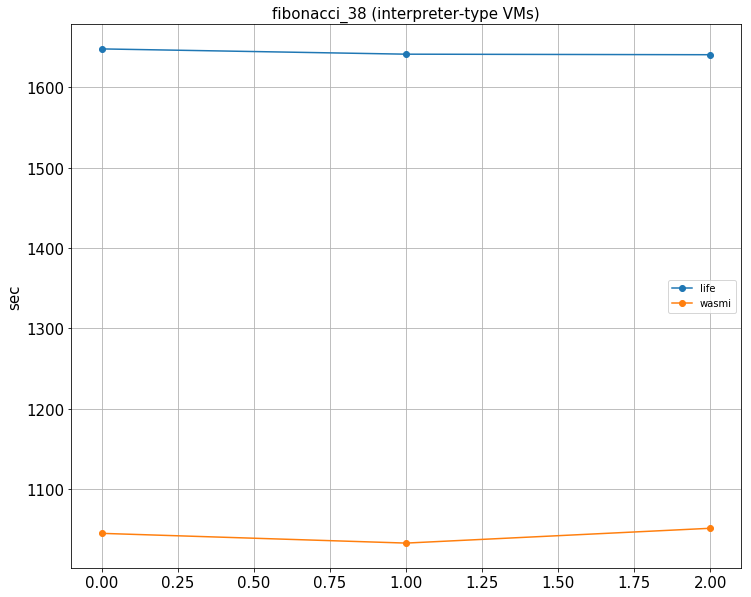

In [42]:
draw_plot(df_results[plot_test_name],  interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

<h3>factorization_2147483647</h3>

In [43]:
plot_test_name="factorization_2147483647"
figsize=(12,10)

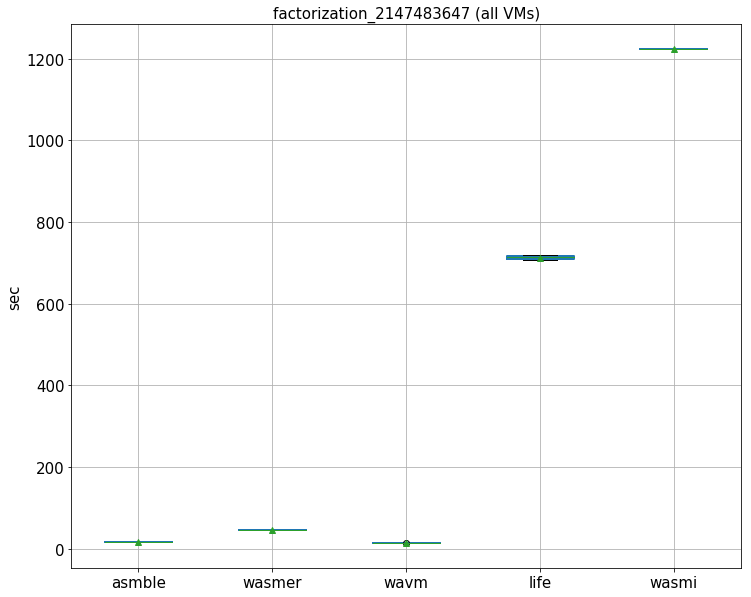

In [44]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize)

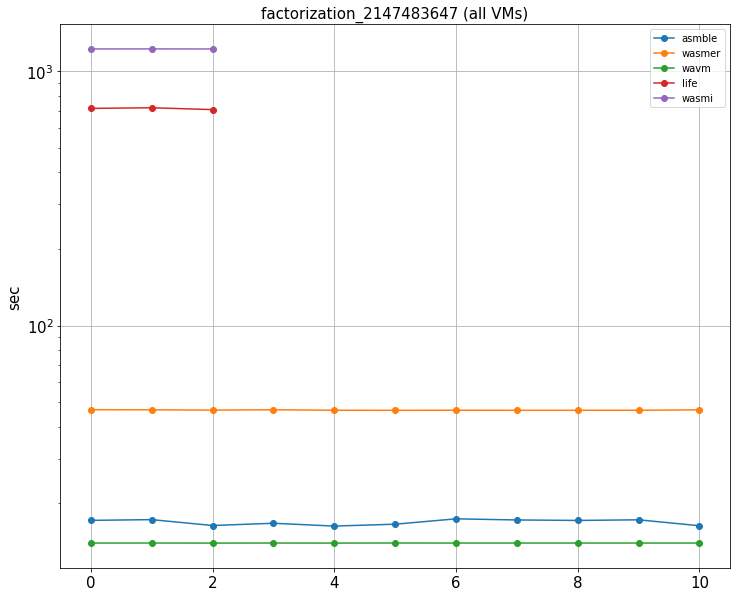

In [45]:
draw_plot(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize, True)

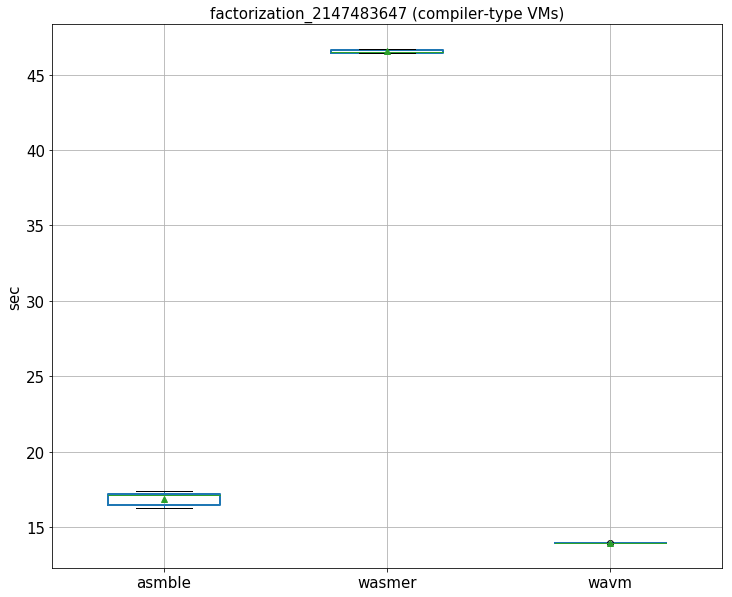

In [46]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

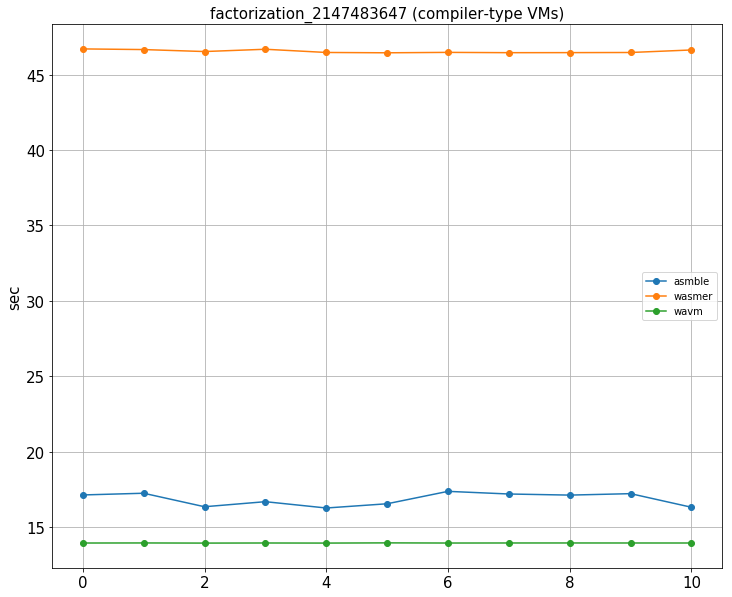

In [47]:
draw_plot(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

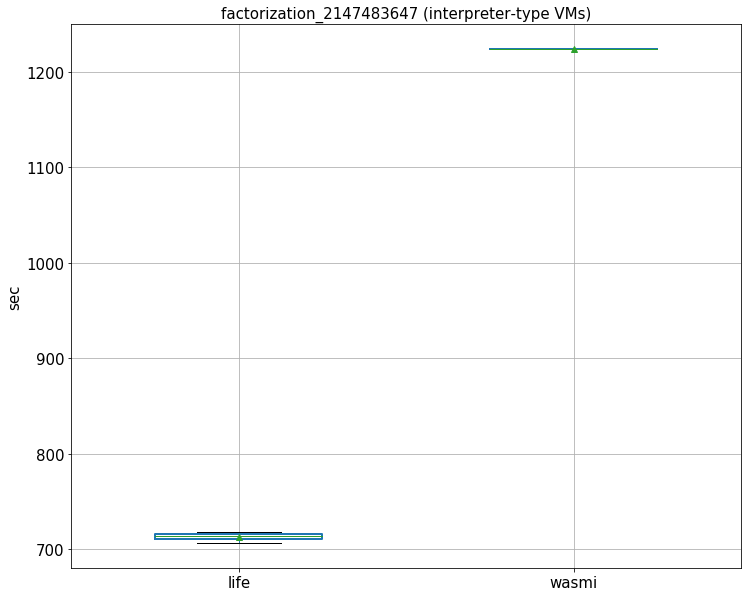

In [48]:
draw_plotbox(df_results[plot_test_name], interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

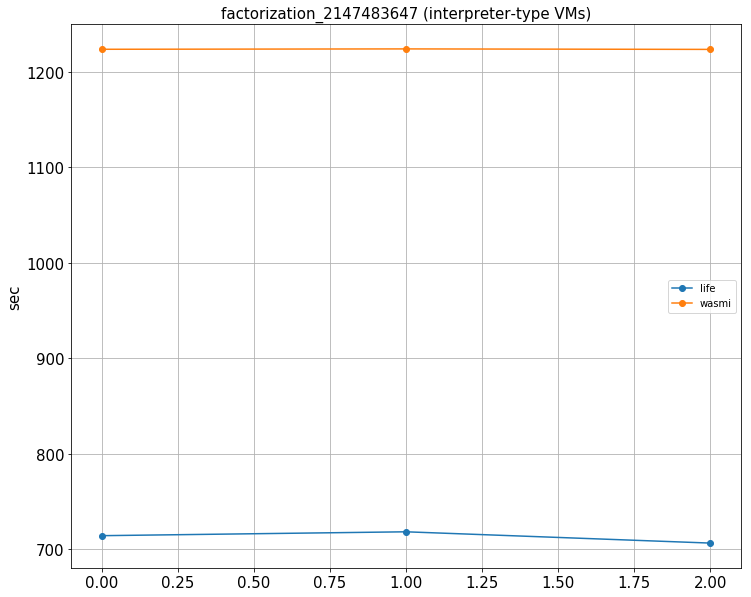

In [49]:
draw_plot(df_results[plot_test_name],  interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

<h3>recursive_hash_10000000_0</h3>

In [50]:
plot_test_name="recursive_hash_10000000_0"
figsize=(12,10)

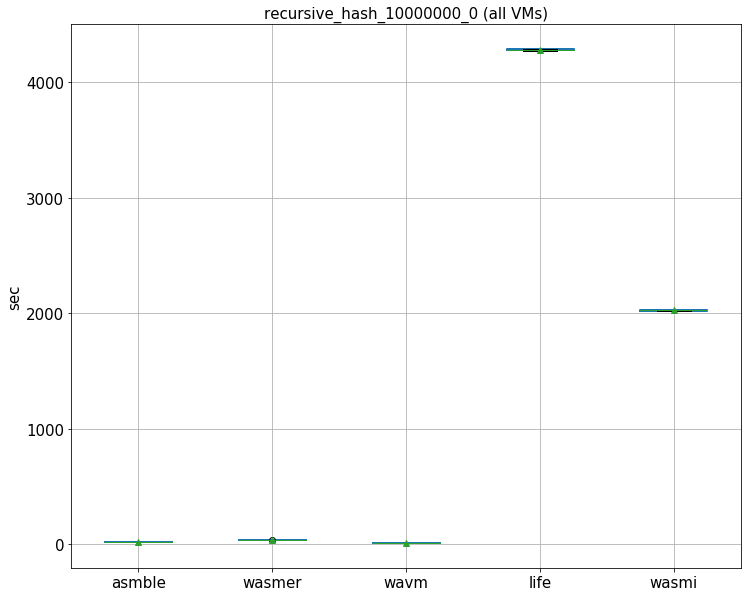

In [51]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize)

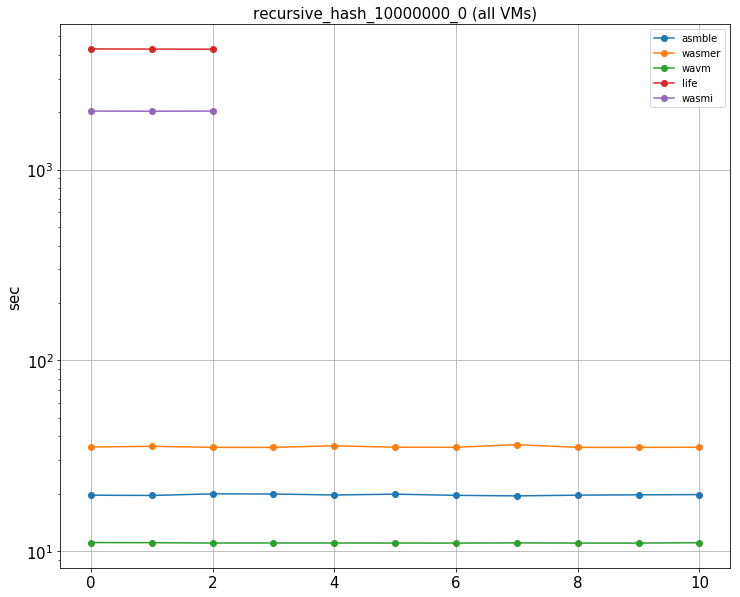

In [52]:
draw_plot(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize, True)

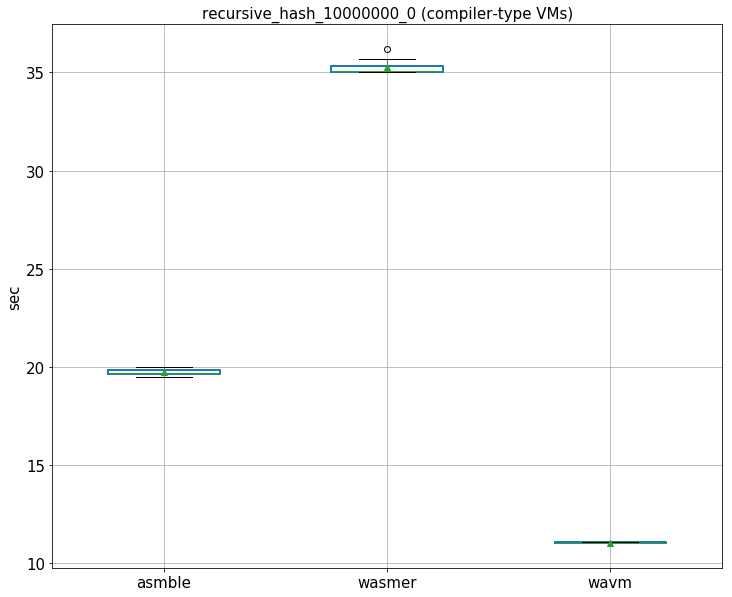

In [53]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

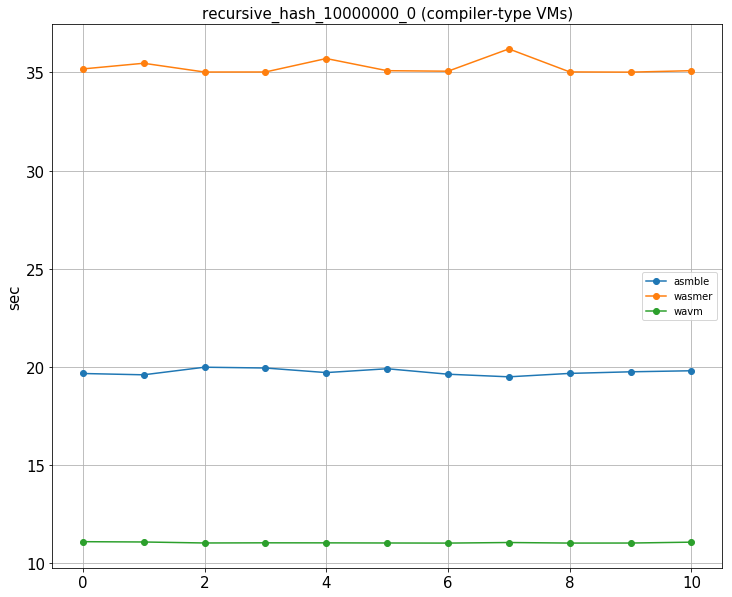

In [54]:
draw_plot(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

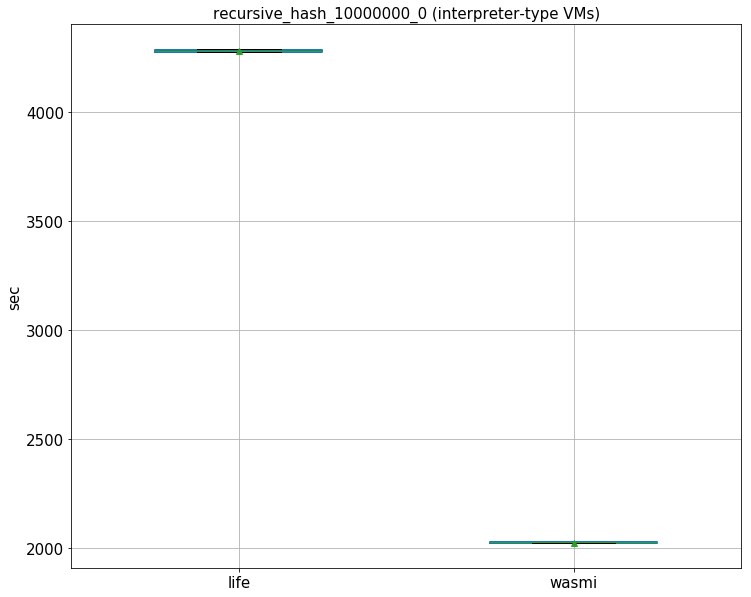

In [55]:
draw_plotbox(df_results[plot_test_name], interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

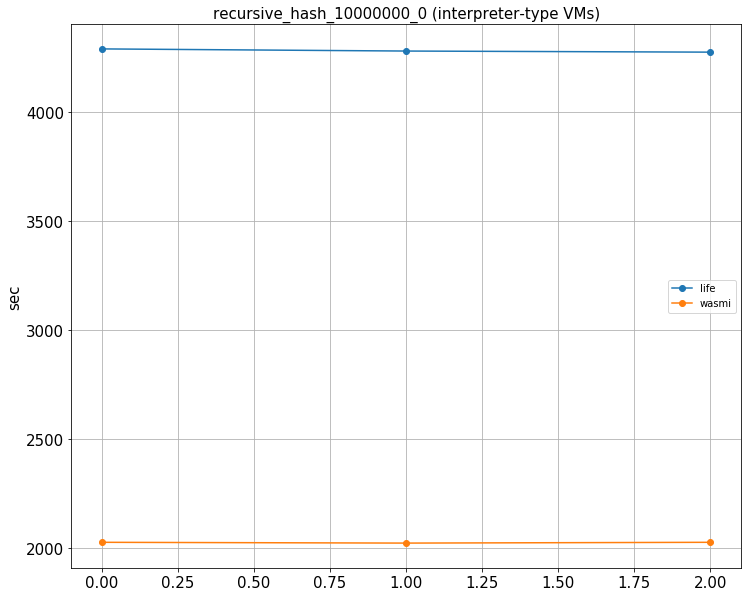

In [56]:
draw_plot(df_results[plot_test_name],  interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

<h3>matrix_product_1_10_1000000</h3>

In [57]:
plot_test_name="matrix_product_1_10_1000000"
figsize=(12,10)

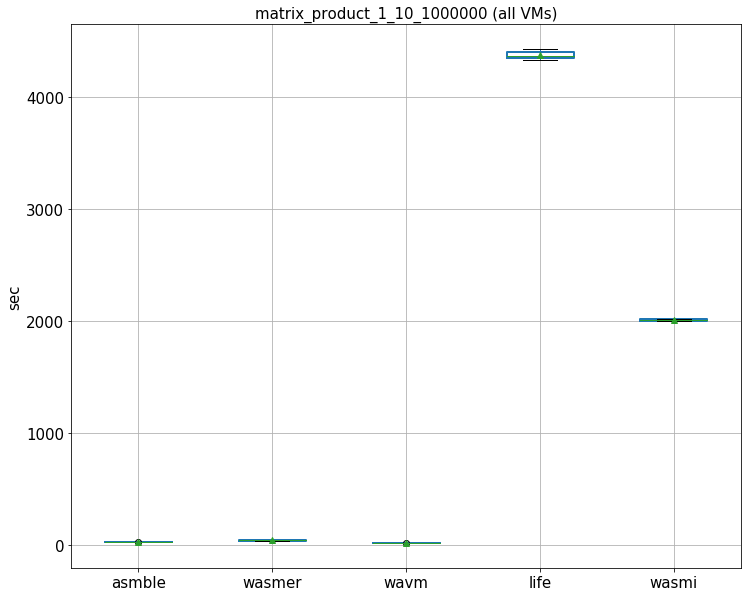

In [58]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize)

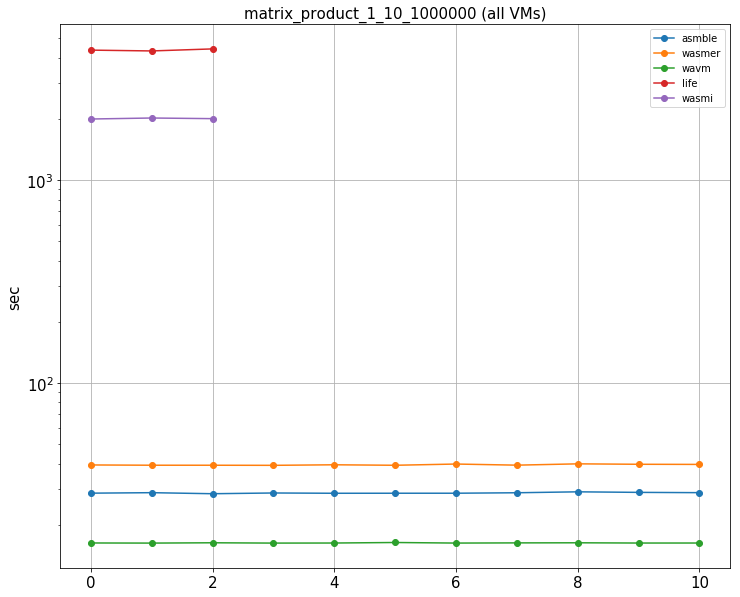

In [59]:
draw_plot(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize, True)

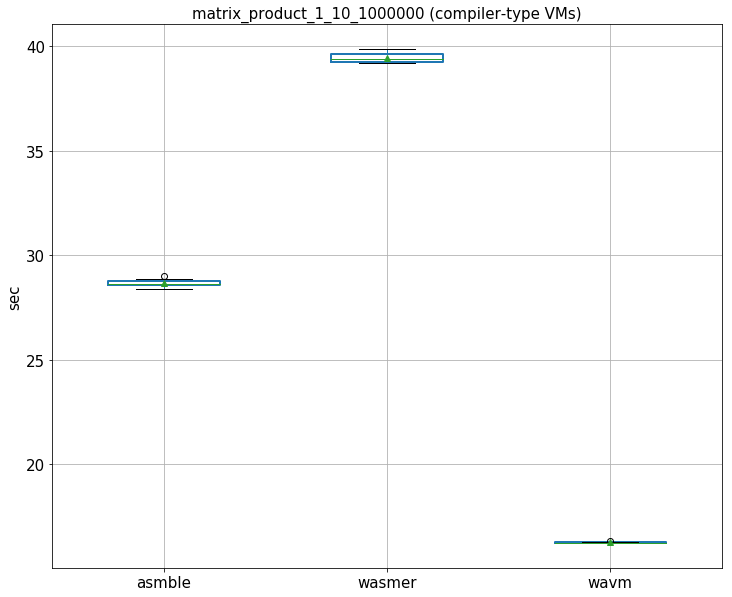

In [60]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

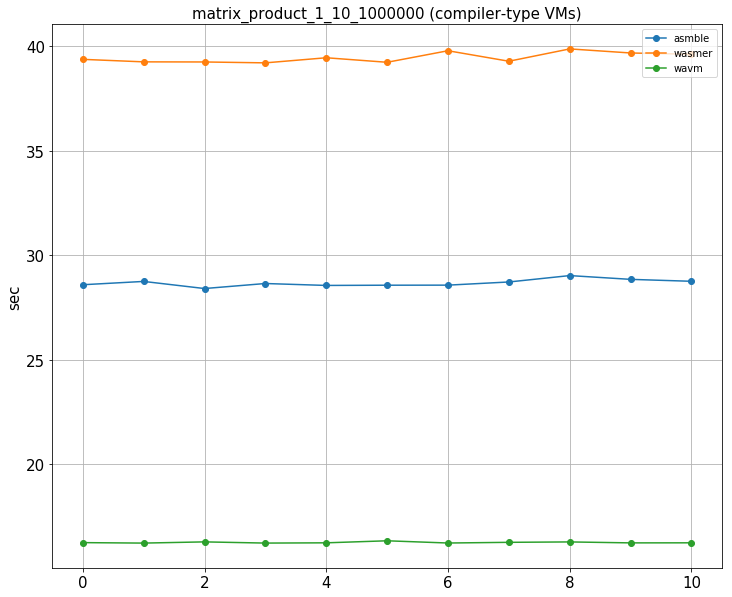

In [61]:
draw_plot(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

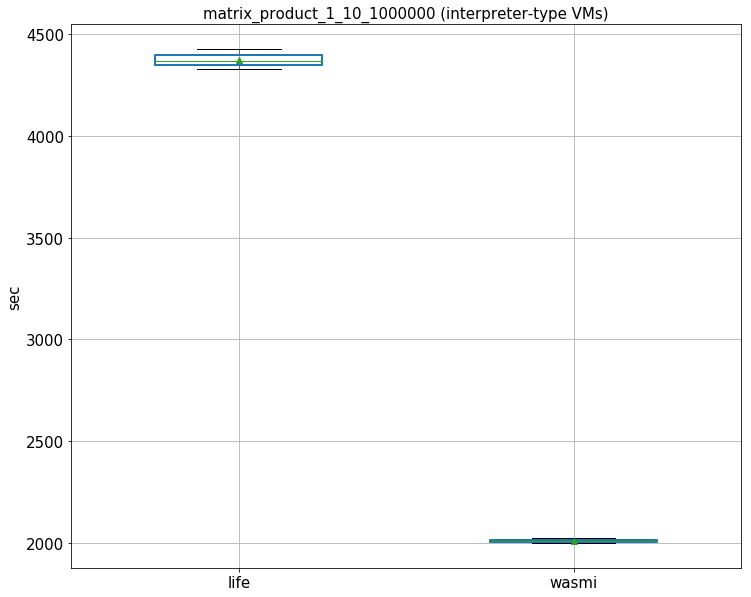

In [62]:
draw_plotbox(df_results[plot_test_name], interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

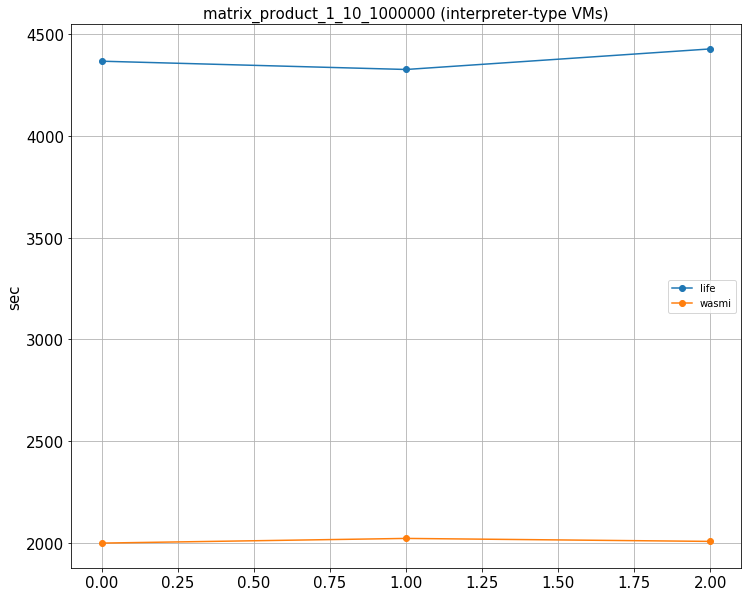

In [63]:
draw_plot(df_results[plot_test_name],  interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

<h3>matrix_product_1_500_100</h3>

In [64]:
plot_test_name="matrix_product_1_500_100"
figsize=(12,10)

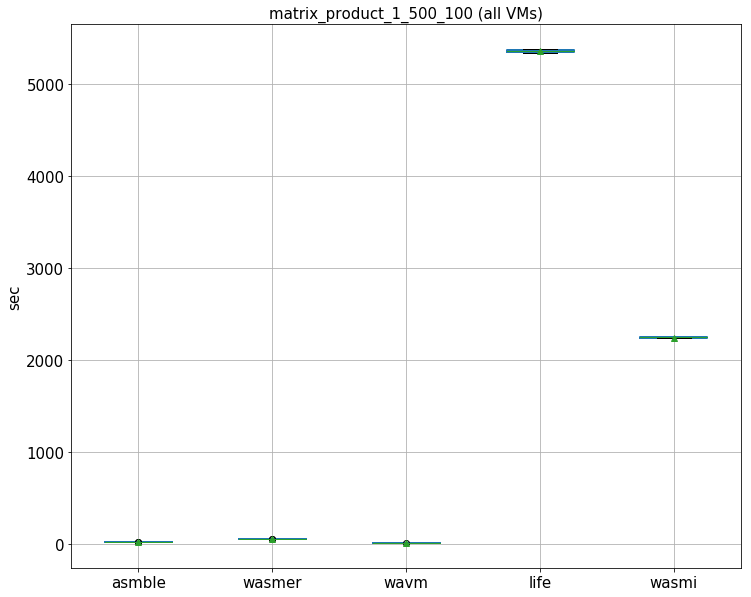

In [65]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize)

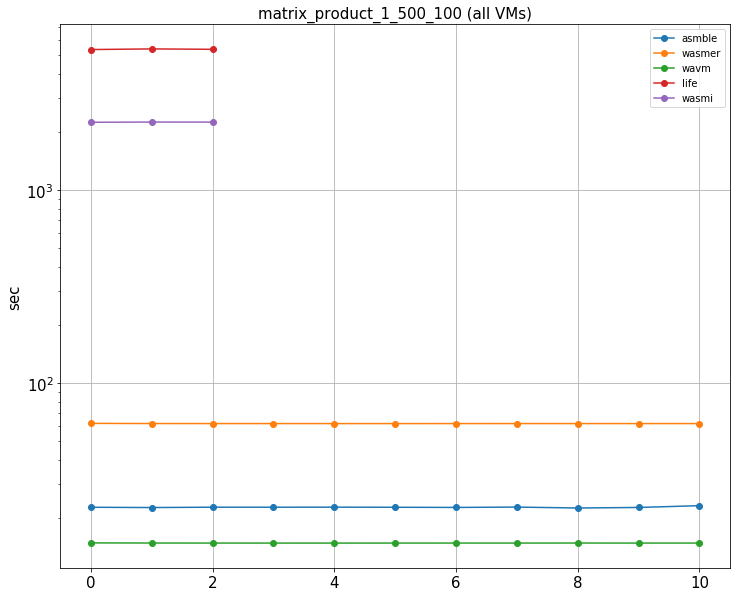

In [66]:
draw_plot(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize, True)

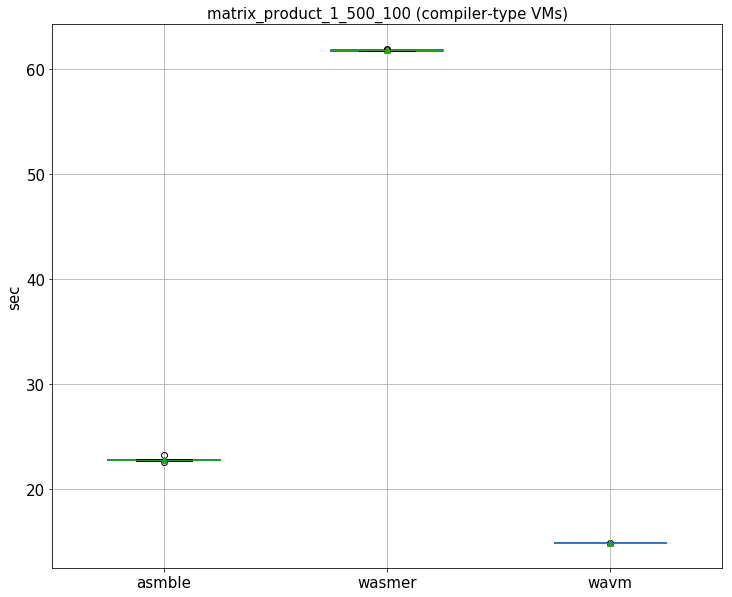

In [67]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

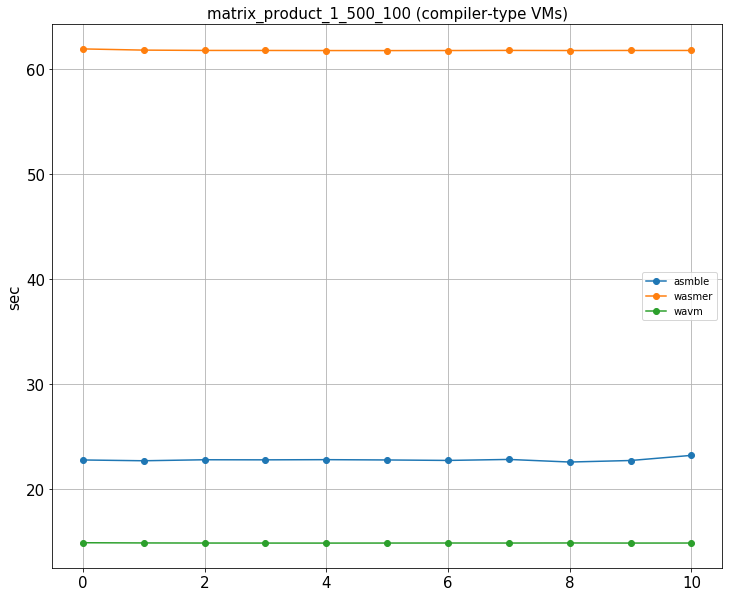

In [68]:
draw_plot(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

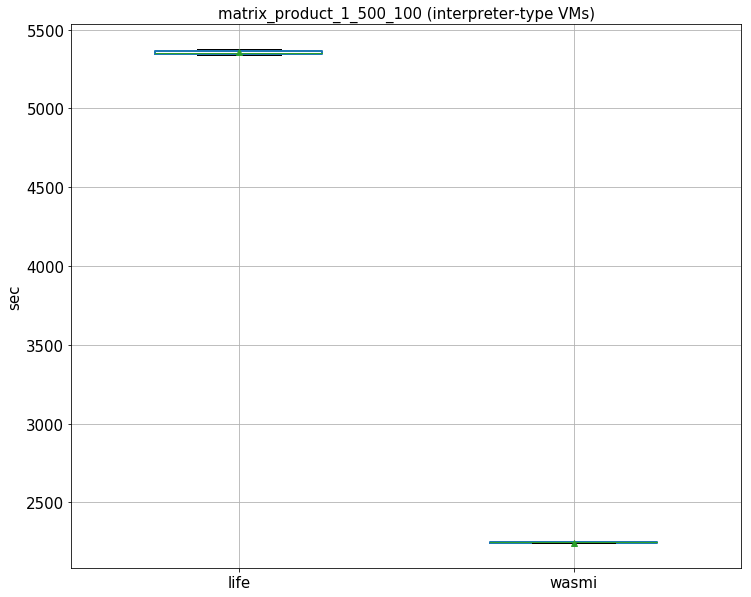

In [69]:
draw_plotbox(df_results[plot_test_name], interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

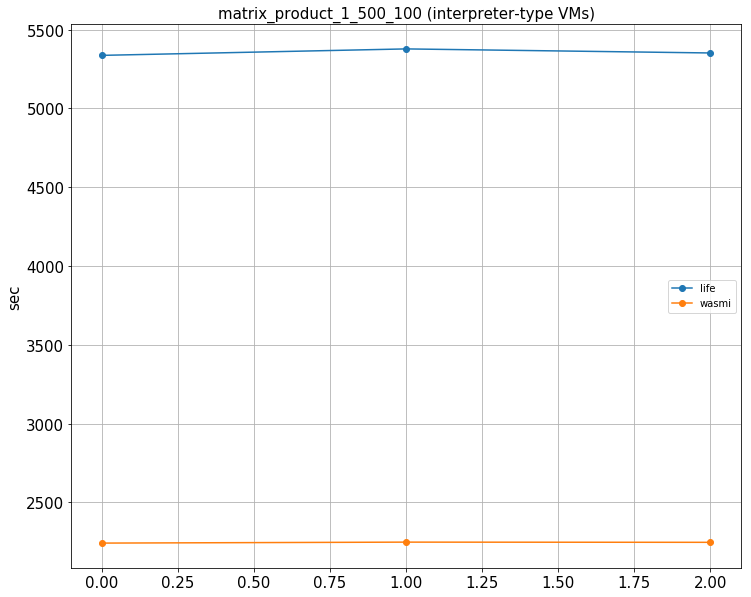

In [70]:
draw_plot(df_results[plot_test_name],  interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

<h3>svd_decomposition_1_10_1000000</h3>

In [71]:
plot_test_name="svd_decomposition_1_10_1000000"
figsize=(12,10)

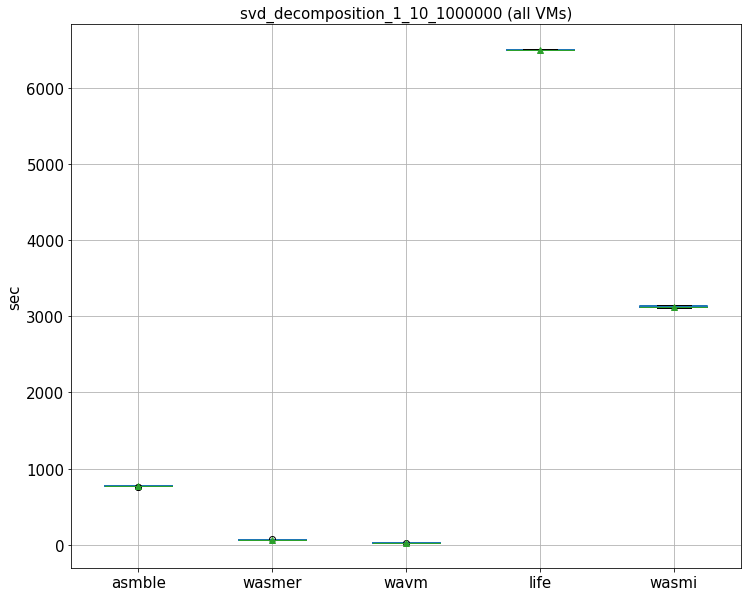

In [72]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize)

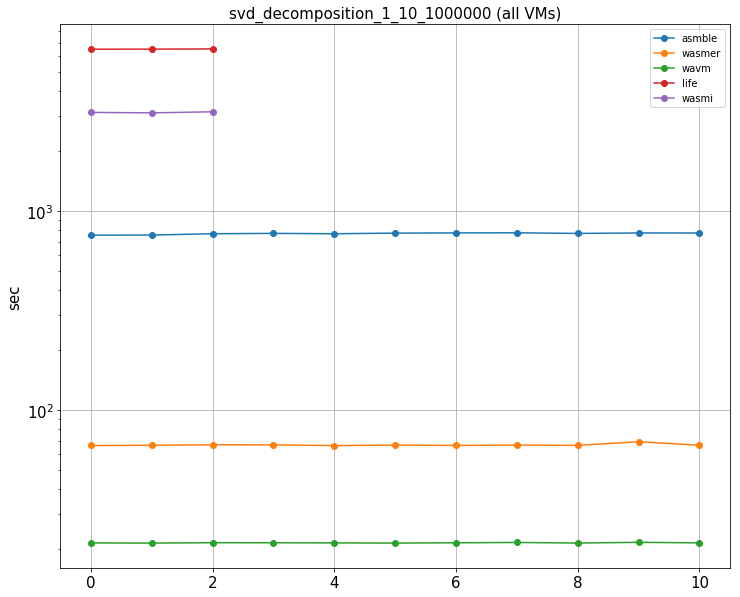

In [73]:
draw_plot(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize, True)

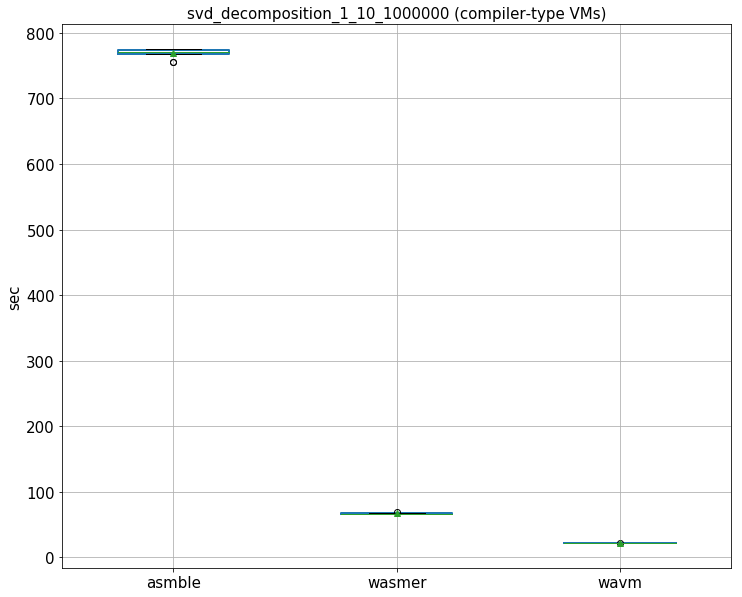

In [74]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

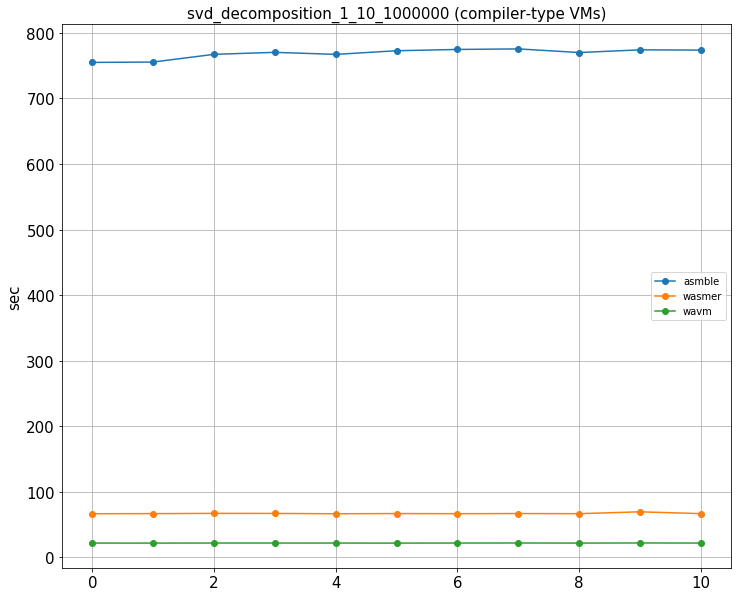

In [75]:
draw_plot(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

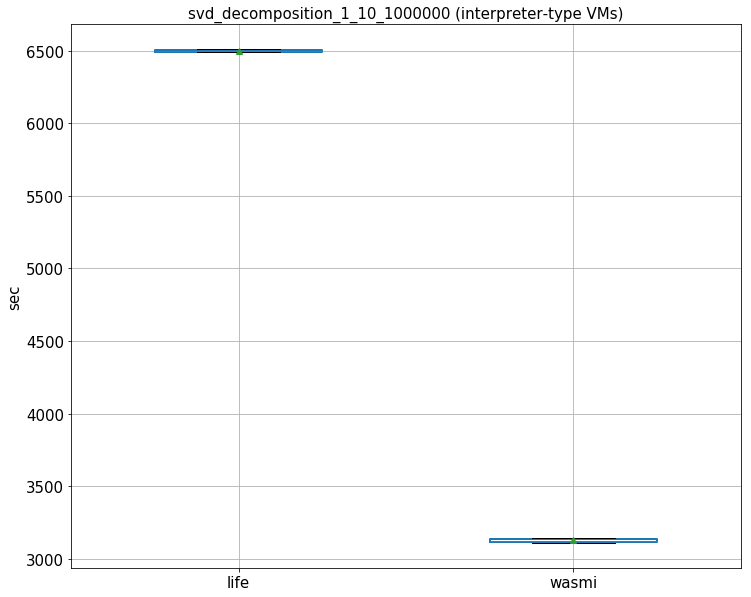

In [76]:
draw_plotbox(df_results[plot_test_name], interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

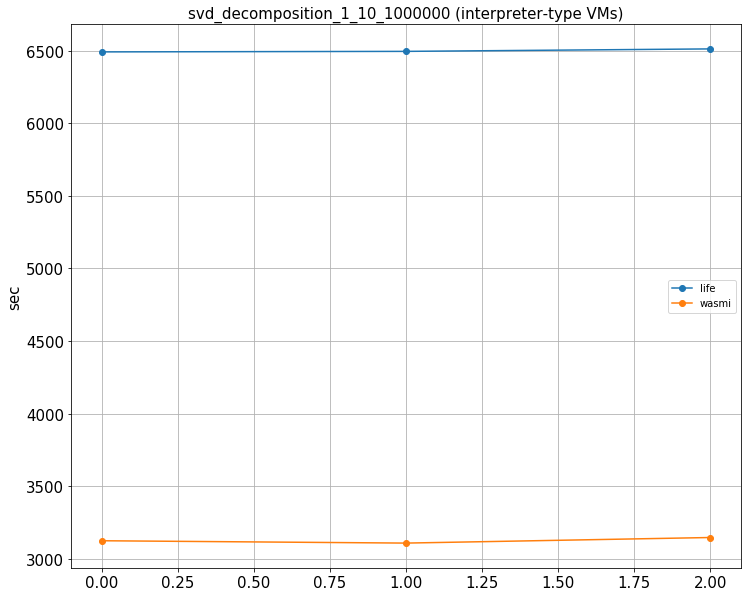

In [77]:
draw_plot(df_results[plot_test_name],  interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

<h3>svd_decomposition_1_300_100</h3>

In [78]:
plot_test_name="svd_decomposition_1_300_100"
figsize=(12,10)

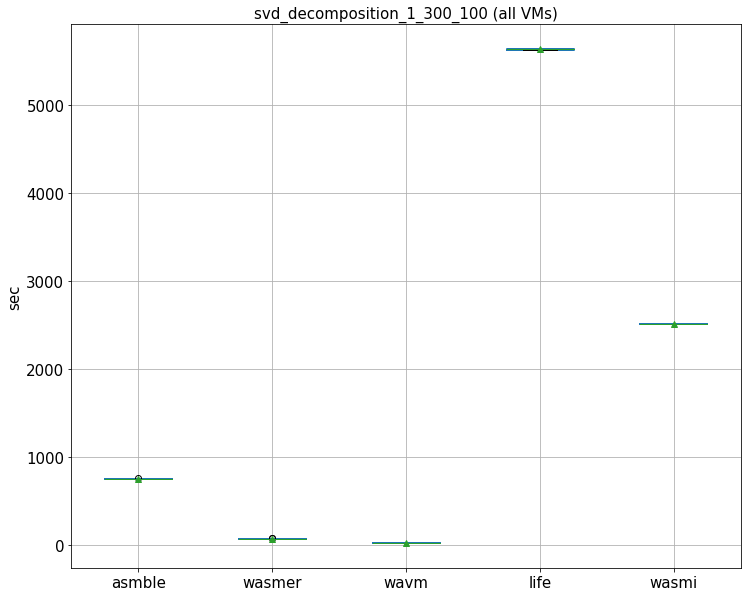

In [79]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize)

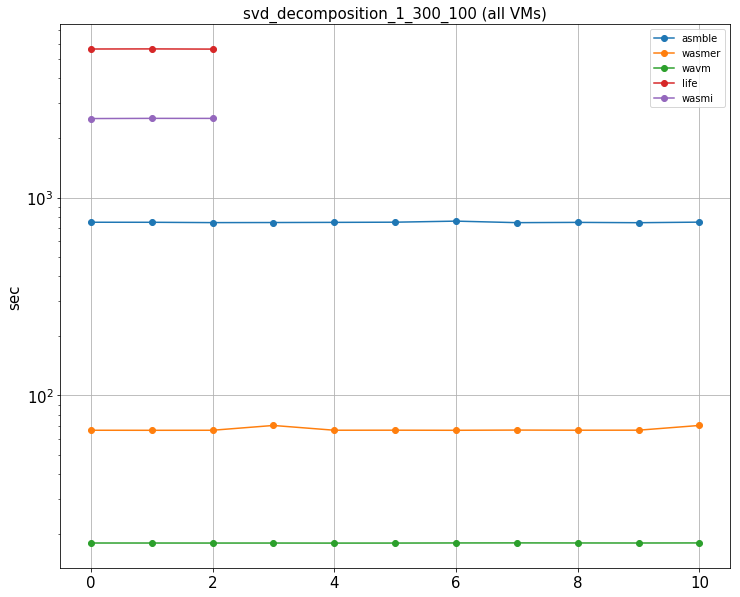

In [80]:
draw_plot(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize, True)

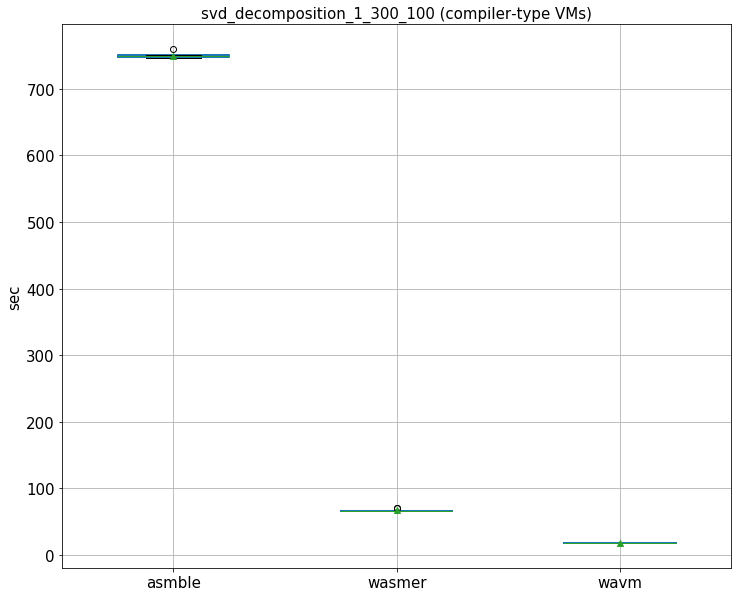

In [81]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

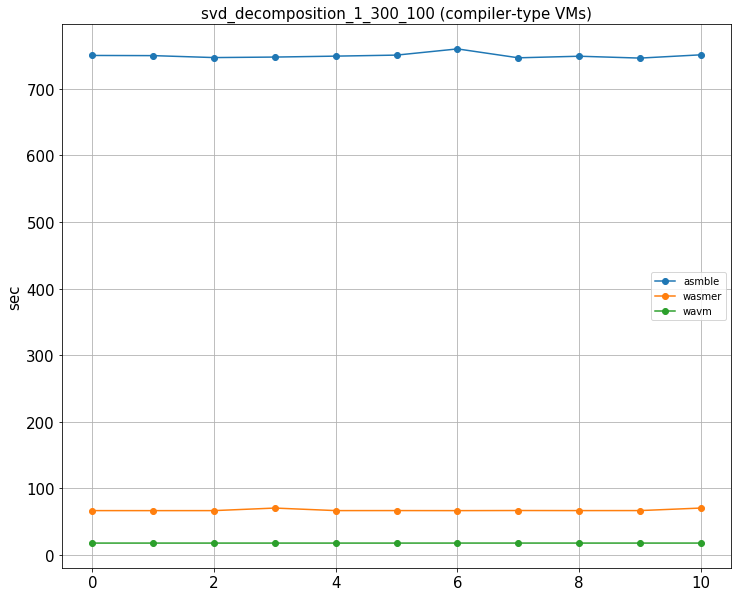

In [82]:
draw_plot(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

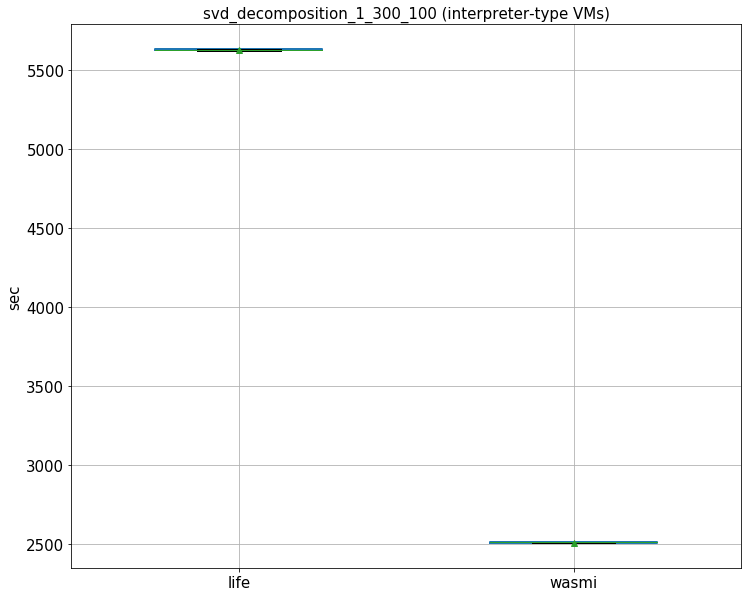

In [83]:
draw_plotbox(df_results[plot_test_name], interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

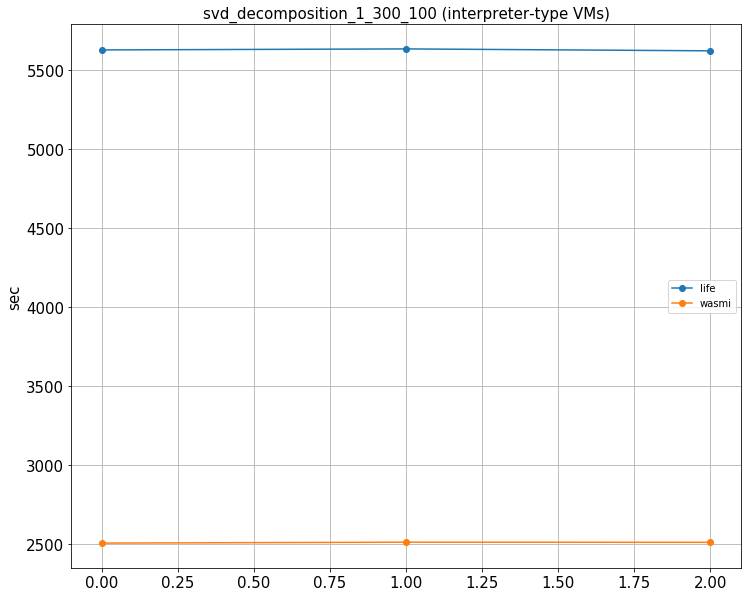

In [84]:
draw_plot(df_results[plot_test_name],  interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

<h3>qr_decomposition_1_10_1000000</h3>

In [85]:
plot_test_name="qr_decomposition_1_10_1000000"
figsize=(12,10)

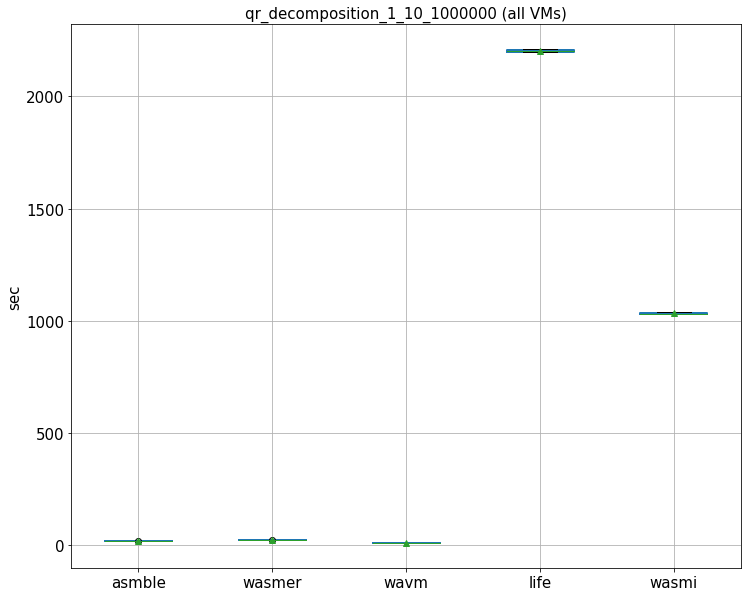

In [86]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize)

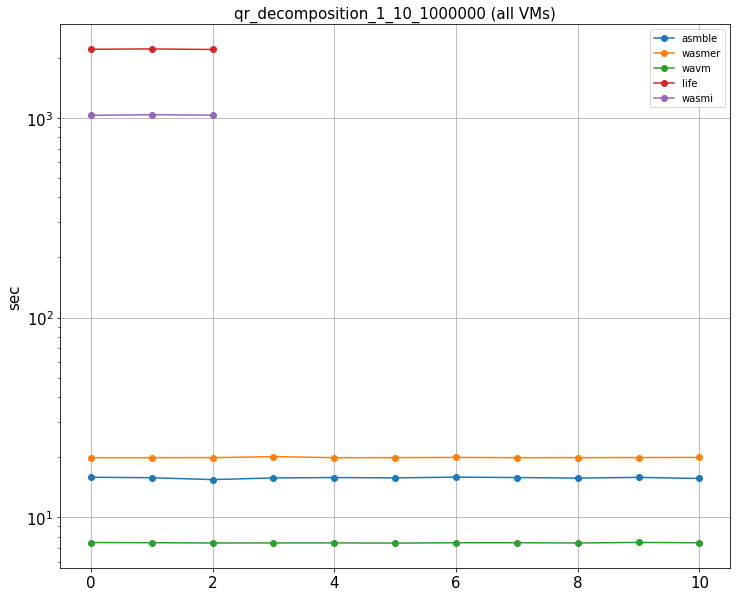

In [87]:
draw_plot(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize, True)

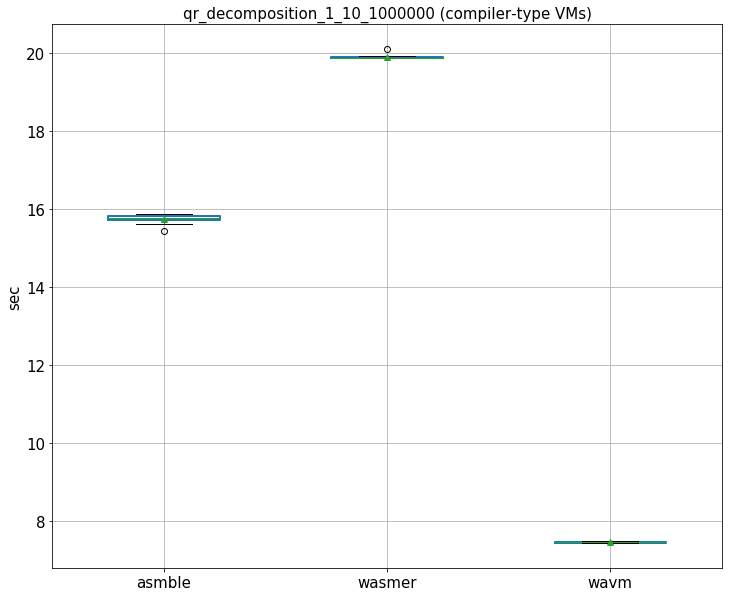

In [88]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

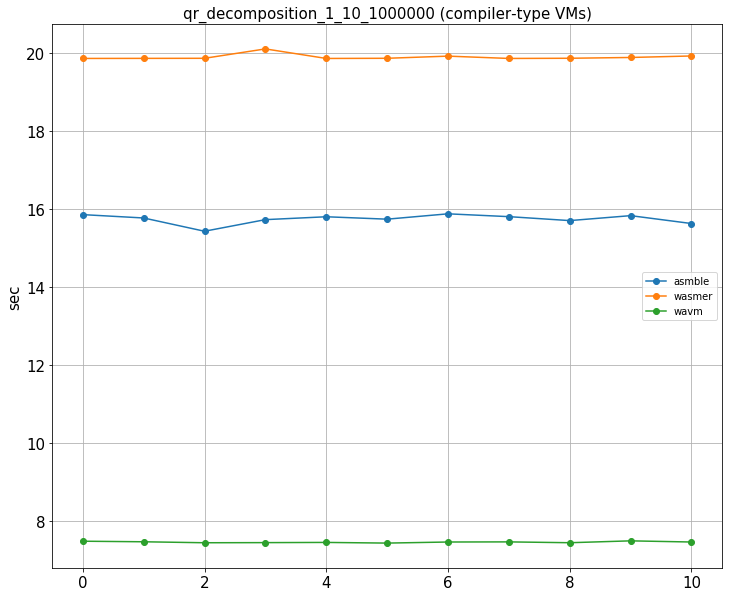

In [89]:
draw_plot(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

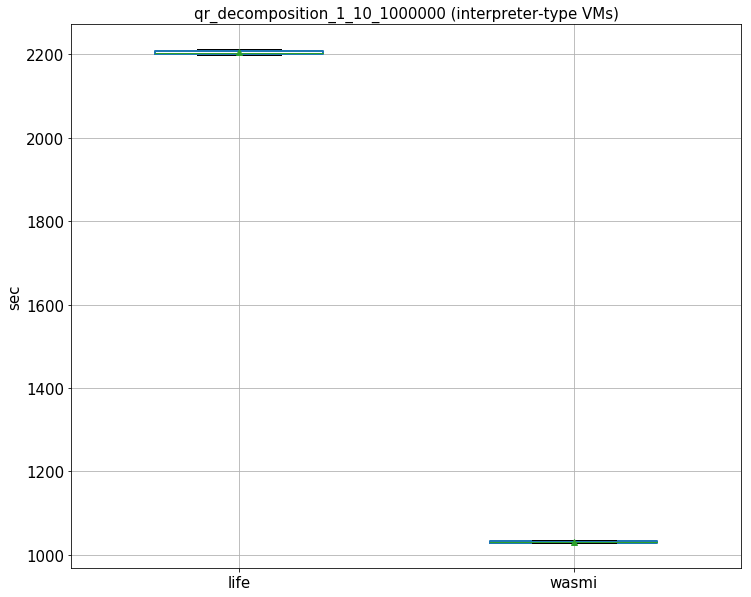

In [90]:
draw_plotbox(df_results[plot_test_name], interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

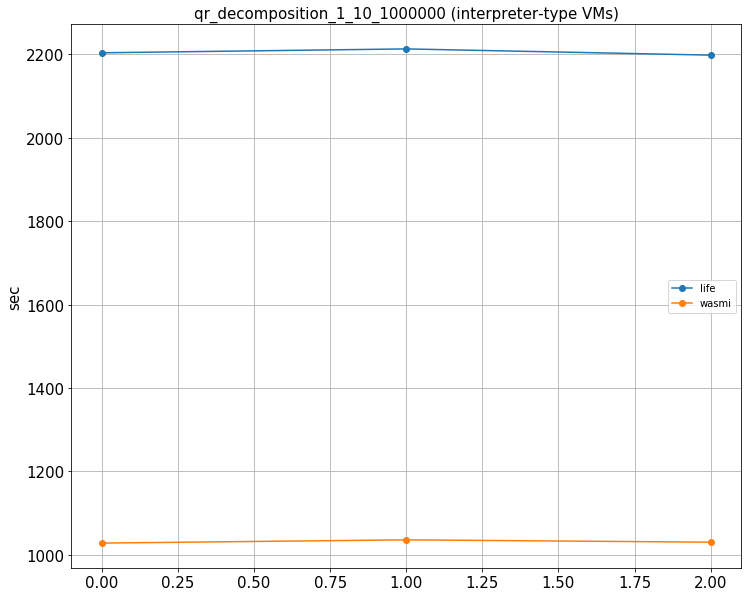

In [91]:
draw_plot(df_results[plot_test_name],  interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

<h3>qr_decomposition_1_500_100</h3>

In [92]:
plot_test_name="qr_decomposition_1_500_100"
figsize=(12,10)

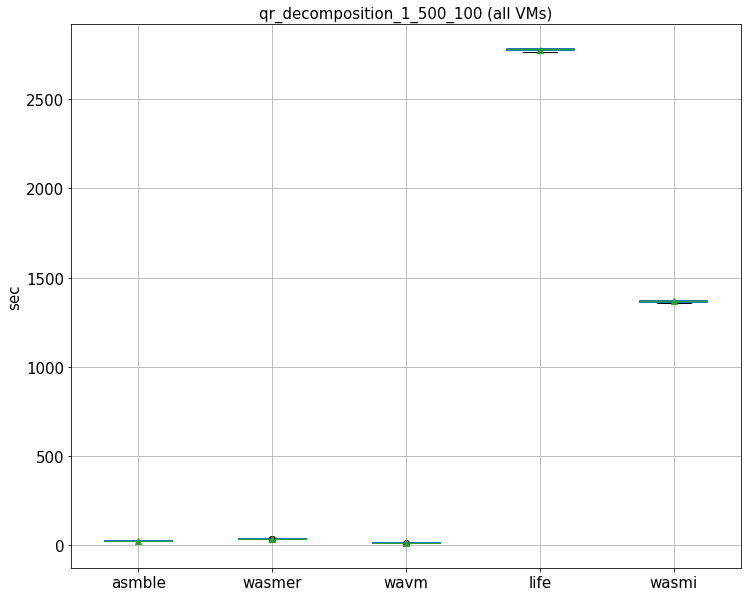

In [93]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize)

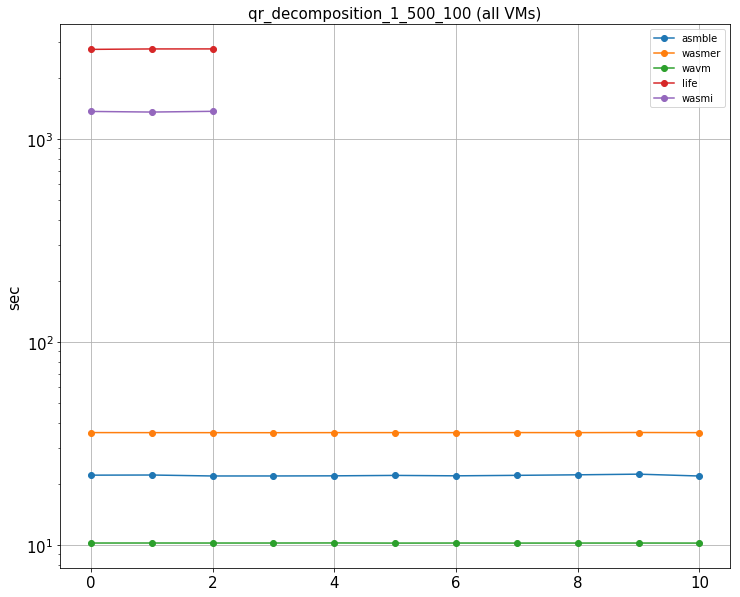

In [94]:
draw_plot(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize, True)

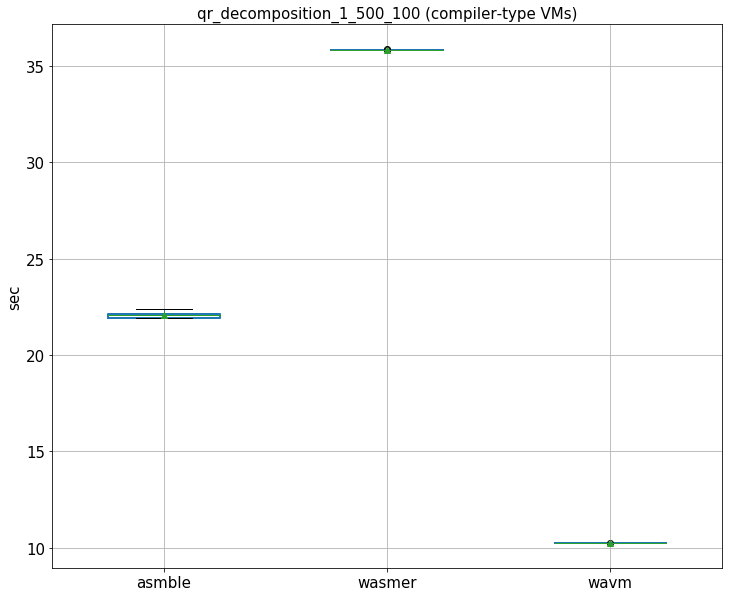

In [95]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

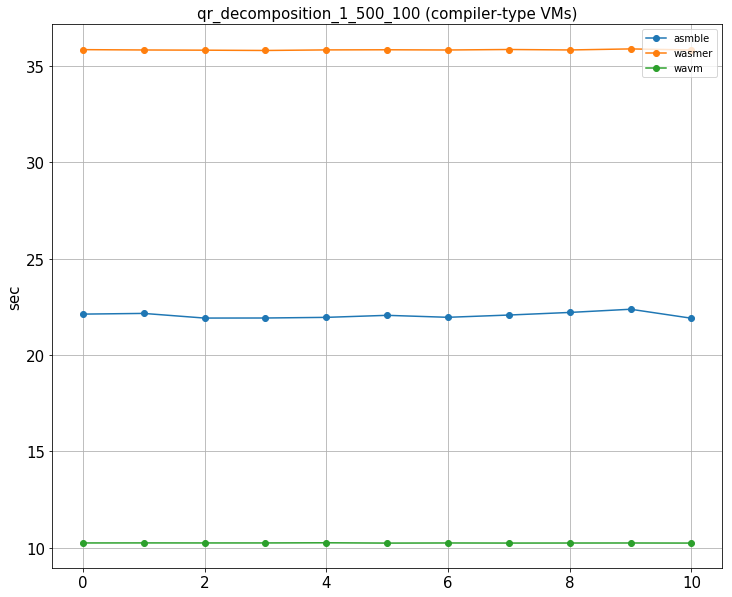

In [96]:
draw_plot(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

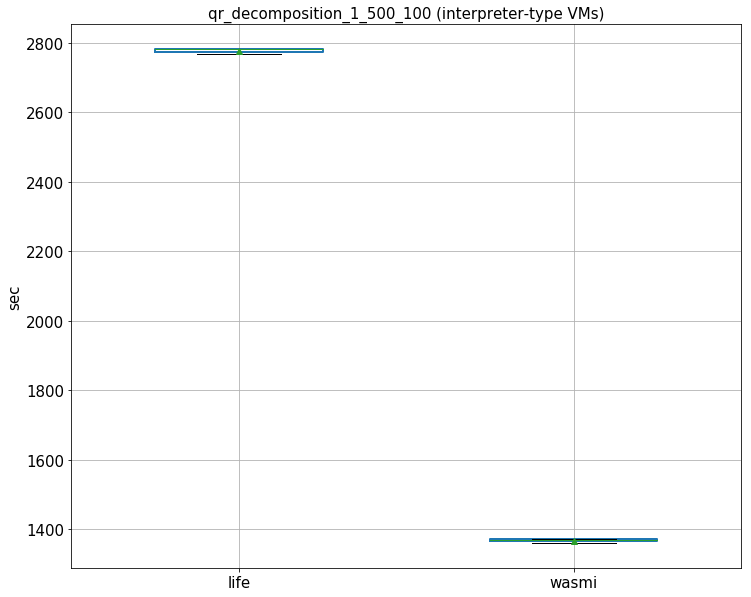

In [97]:
draw_plotbox(df_results[plot_test_name], interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

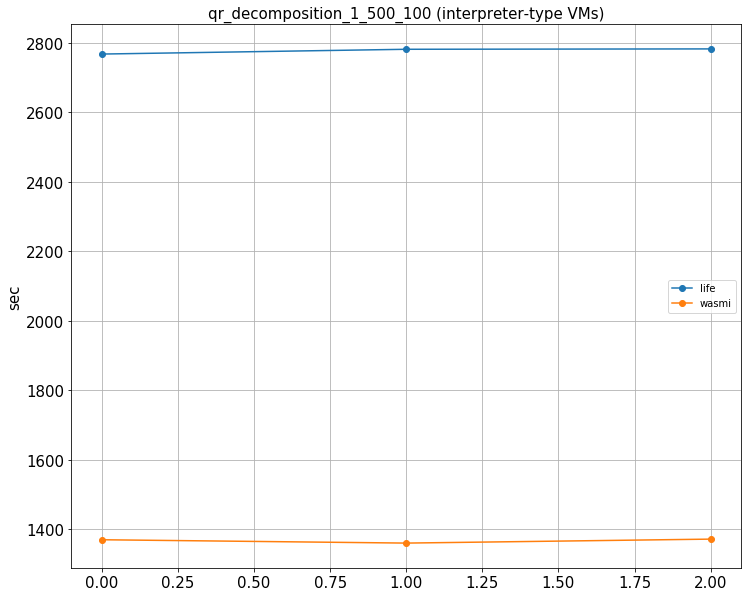

In [98]:
draw_plot(df_results[plot_test_name],  interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)